In [2]:
from trace_IO import *
from OF_trigger import *
from tools import *
import matplotlib.pyplot as plt
import numpy as np


sampling_frequency = 3906250


template = np.load("../templates/template_K_alpha_no_baseline.npy")
noise_psd = np.load("../templates/noise_psd_from_MMC.npy")
# Parameters

# Initialize Optimum Filter
trigger = OFtrigger(template, noise_psd, sampling_frequency)



Processing energies: 100%|██████████| 21/21 [04:20<00:00, 12.38s/it]


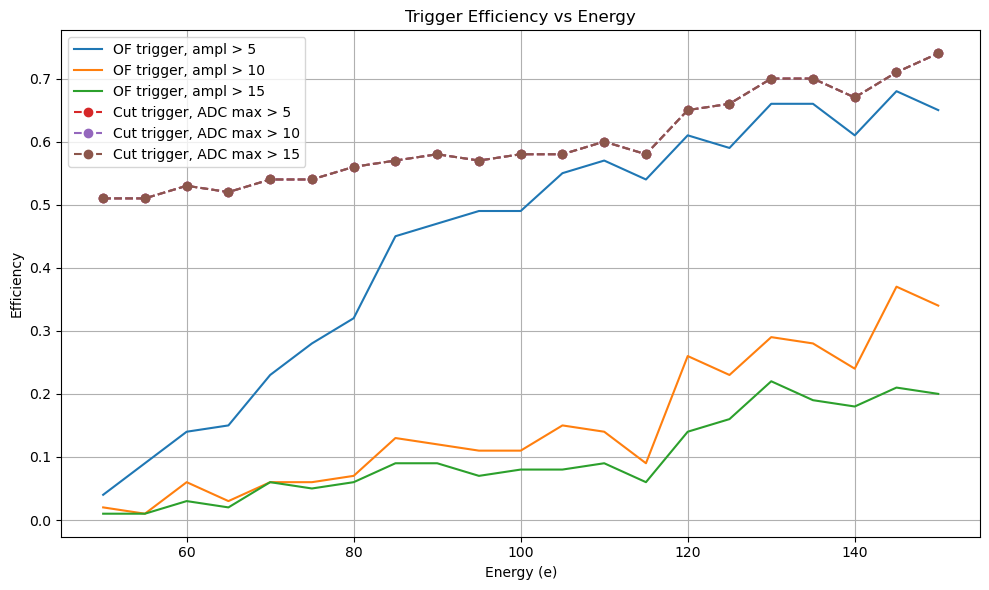

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Parameters
n_sets = 100
thresholds = [5, 10, 15]  # Ensure this order is preserved throughout
energies = np.arange(50, 151, 5)

cut_pass_rates = {thr: [] for thr in thresholds}
of_pass_rates = {thr: [] for thr in thresholds}

# Store passed event amplitudes for later analysis
cut_passed_amplitudes = {thr: {'max': [], 'of': []} for thr in thresholds}
of_passed_amplitudes = {thr: {'max': [], 'of': []} for thr in thresholds}

# Process all energies
for energy in tqdm(energies, desc="Processing energies"):
    trace_path = f"/ceph/dwong/trigger_samples/traces_energy_{energy}.zst"
    loaded_traces = load_traces_from_zstd(trace_path, n_traces=n_sets)

    # Collect max amplitudes and OF amplitudes
    max_amplitudes_all = []
    of_amplitudes_all = []

    for i in range(n_sets):
        trace_max_vals = []
        trace_of_vals = []
        for trace in loaded_traces[i]:
            max_val = np.max(trace)
            of_val = trigger.fit_with_shift(trace)[0]
            trace_max_vals.append(max_val)
            trace_of_vals.append(of_val)

        # Use max of each trace group
        max_amplitudes_all.append(max(trace_max_vals))
        of_amplitudes_all.append(max(trace_of_vals))

    max_amplitudes_all = np.array(max_amplitudes_all)
    of_amplitudes_all = np.array(of_amplitudes_all)

    for thr in thresholds:
        # OF trigger
        of_pass_mask = of_amplitudes_all > thr
        of_pass_rate = np.sum(of_pass_mask) / len(of_amplitudes_all)
        of_pass_rates[thr].append(of_pass_rate)
        of_passed_amplitudes[thr]['max'].extend(max_amplitudes_all[of_pass_mask])
        of_passed_amplitudes[thr]['of'].extend(of_amplitudes_all[of_pass_mask])

        # Cut trigger
        cut_pass_mask = max_amplitudes_all > thr
        cut_pass_rate = np.sum(cut_pass_mask) / len(max_amplitudes_all)
        cut_pass_rates[thr].append(cut_pass_rate)
        cut_passed_amplitudes[thr]['max'].extend(max_amplitudes_all[cut_pass_mask])
        cut_passed_amplitudes[thr]['of'].extend(of_amplitudes_all[cut_pass_mask])

# Plotting combined efficiency
plt.figure(figsize=(10, 6))
for thr in thresholds:
    plt.plot(energies, of_pass_rates[thr], label=f'OF trigger, ampl > {thr}')
for thr in thresholds:
    plt.plot(energies, cut_pass_rates[thr], linestyle='--', marker='o', label=f'Cut trigger, ADC max > {thr}')

plt.xlabel('Energy (e)')
plt.ylabel('Efficiency')
plt.title('Trigger Efficiency vs Energy')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [14]:
cut_pass_rates[15]

[0.5001851851851852,
 0.5001851851851852,
 0.5005555555555555,
 0.5003703703703704,
 0.5007407407407407,
 0.5007407407407407,
 0.5011111111111111,
 0.5014814814814815,
 0.5014814814814815,
 0.5012962962962964,
 0.5014814814814815,
 0.5016666666666667,
 0.5018518518518519,
 0.5014814814814815,
 0.5033333333333333,
 0.5031481481481481,
 0.5038888888888889,
 0.5038888888888889,
 0.5035185185185185,
 0.5046296296296297,
 0.5048148148148148]

Processing energies: 100%|██████████| 21/21 [03:40<00:00, 10.49s/it]


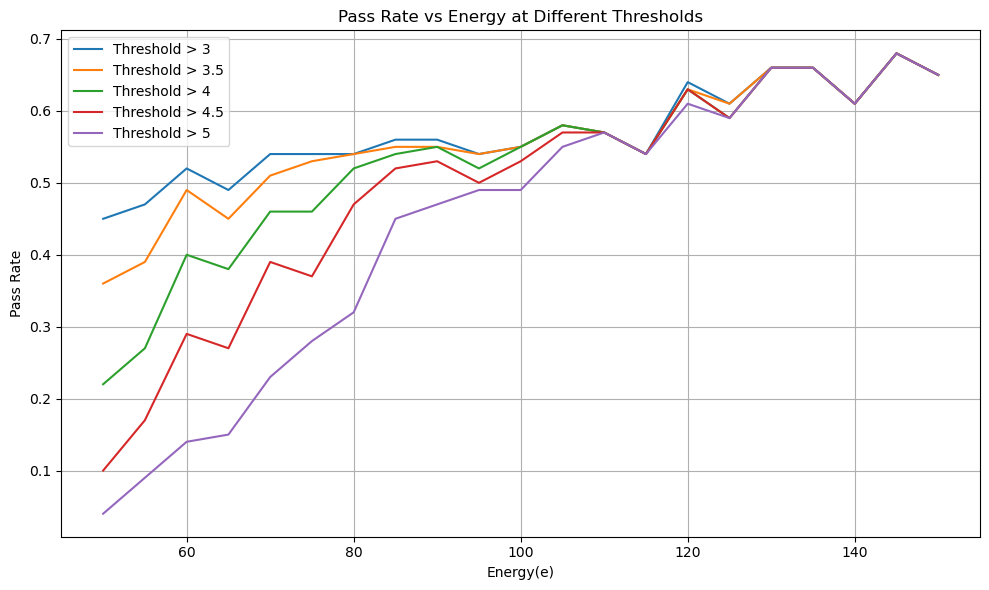

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

energy_values = list(range(50, 151, 5))
thresholds = [3, 3.5, 4, 4.5, 5]
pass_rates_by_threshold = {th: [] for th in thresholds}

n_sets = 100  # Adjust as needed

for energy in tqdm(energy_values, desc="Processing energies"):
    trace_path = f"/ceph/dwong/trigger_samples/traces_energy_{energy}.zst"
    loaded_traces = load_traces_from_zstd(trace_path, n_traces=n_sets)

    max_amplitudes = []

    for i in range(n_sets):
        amps = [trigger.fit_with_shift(trace)[0] for trace in loaded_traces[i]]
        max_amplitudes.append(np.max(amps))

    max_amplitudes = np.array(max_amplitudes)

    for th in thresholds:
        pass_rate = np.sum(max_amplitudes > th) / n_sets
        pass_rates_by_threshold[th].append(pass_rate)

# Plotting
plt.figure(figsize=(10, 6))
for th in thresholds:
    plt.plot(energy_values, pass_rates_by_threshold[th], label=f'Threshold > {th}')

plt.xlabel('Energy(e)')
plt.ylabel('Pass Rate')
plt.title('Pass Rate vs Energy at Different Thresholds')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


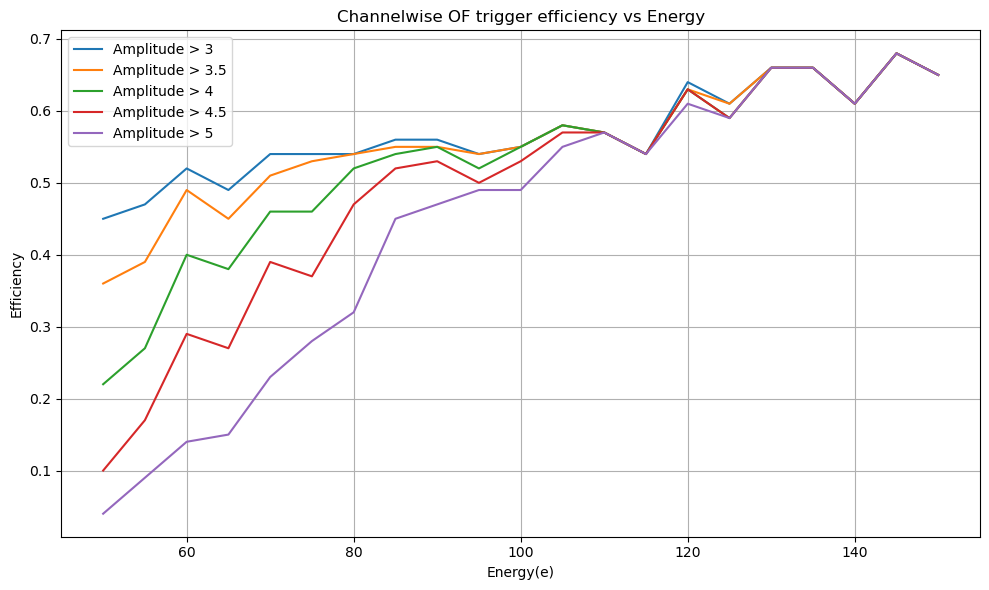

In [40]:
plt.figure(figsize=(10, 6))
for th in thresholds:
    plt.plot(energy_values, pass_rates_by_threshold[th], label=f'Amplitude > {th}')

plt.xlabel('Energy(e)')
plt.ylabel('Efficiency')
plt.title('Channelwise OF trigger efficiency vs Energy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Processing energies: 100%|██████████| 21/21 [01:03<00:00,  3.02s/it]


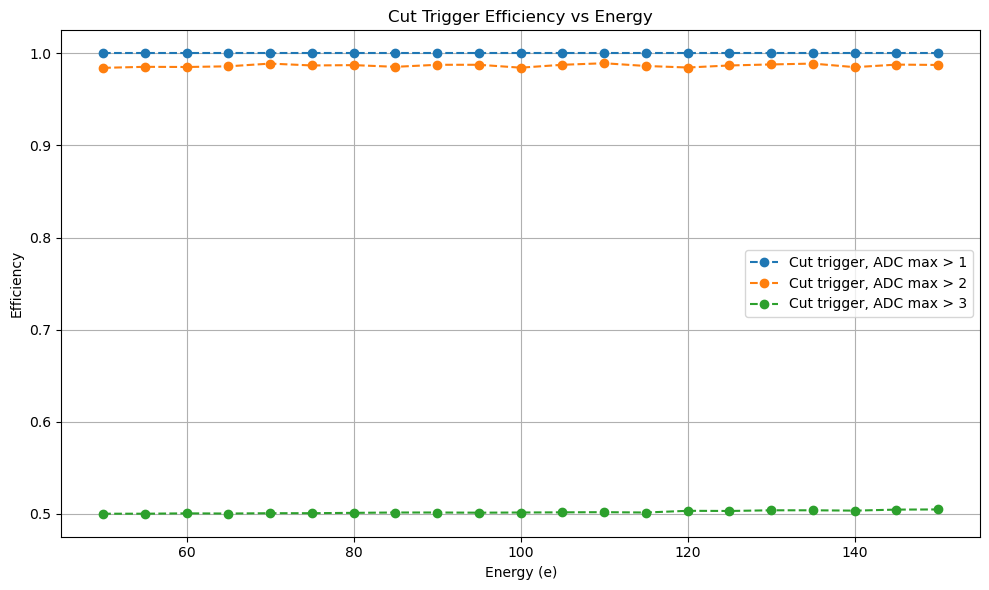

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Parameters
n_sets = 100
thresholds = [1, 2, 3]  # Ensure this order is preserved throughout
energies = np.arange(50, 151, 5)

cut_pass_rates = {thr: [] for thr in thresholds}
cut_passed_amplitudes = {thr: {'max': []} for thr in thresholds}

# Process all energies
for energy in tqdm(energies, desc="Processing energies"):
    trace_path = f"/ceph/dwong/trigger_samples/traces_energy_{energy}.zst"
    loaded_traces = load_traces_from_zstd(trace_path, n_traces=n_sets)

    max_amplitudes_all = []

    for i in range(n_sets):
        for trace in loaded_traces[i]:
            max_val = np.max(trace)
            max_amplitudes_all.append(max_val)

    max_amplitudes_all = np.array(max_amplitudes_all)
    total_traces = len(max_amplitudes_all)

    for thr in thresholds:
        cut_pass_mask = max_amplitudes_all > thr
        cut_pass_rate = np.sum(cut_pass_mask) / total_traces
        cut_pass_rates[thr].append(cut_pass_rate)
        cut_passed_amplitudes[thr]['max'].extend(max_amplitudes_all[cut_pass_mask])

# Plotting cut trigger efficiency
plt.figure(figsize=(10, 6))
for thr in thresholds:
    plt.plot(energies, cut_pass_rates[thr], linestyle='--', marker='o', label=f'Cut trigger, ADC max > {thr}')

plt.xlabel('Energy (e)')
plt.ylabel('Efficiency')
plt.title('Cut Trigger Efficiency vs Energy')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [25]:
import numpy as np
from tqdm import tqdm

# Parameters
energy = 0
n_sets = 1000
trace_path = f"/ceph/dwong/trigger_samples/traces_energy_{energy}.zst"

# Load traces
loaded_traces = load_traces_from_zstd(trace_path, n_traces=n_sets)

# Placeholder arrays
of_amplitudes = []

# Loop over traces
for i in tqdm(range(n_sets), desc="Computing OF and max amplitudes"):
    traces = loaded_traces[i]

    # Compute OF amplitudes
    amps = [trigger.fit(trace)[0] for trace in traces]
    of_amplitudes.extend(amps)


# Convert to numpy arrays
of_amplitudes = np.array(of_amplitudes)




Computing OF and max amplitudes: 100%|██████████| 1000/1000 [00:40<00:00, 24.64it/s]


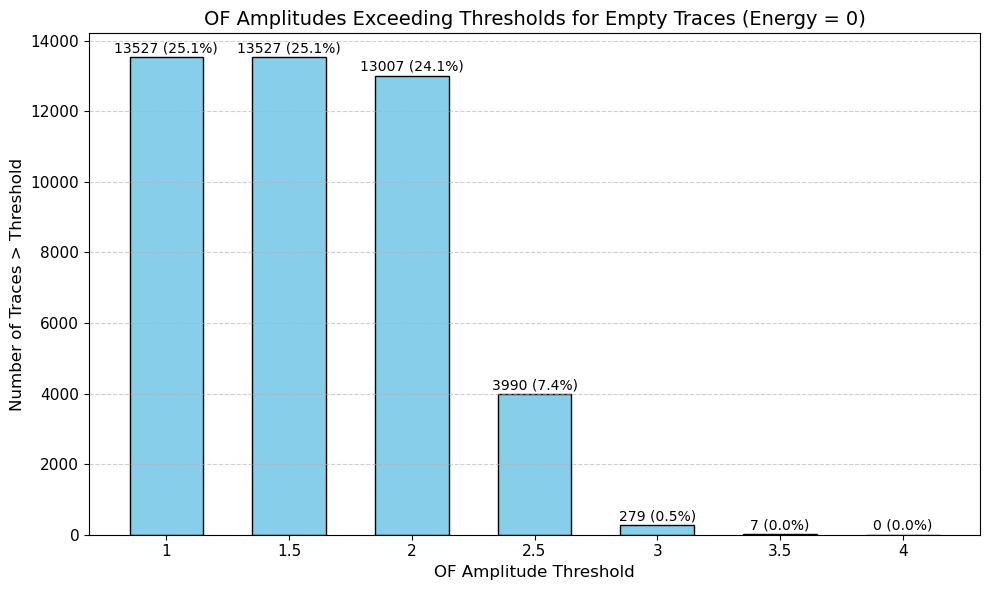

In [36]:
import matplotlib.pyplot as plt
import numpy as np

# Define amplitude thresholds
thresholds = [1, 1.5, 2, 2.5, 3, 3.5, 4]
of_amplitudes = np.array(of_amplitudes)
total_traces = 54000

# Count how many amplitudes exceed each threshold
counts_of = [np.sum(of_amplitudes > thr) for thr in thresholds]
percentages = [100 * count / total_traces for count in counts_of]

# Plotting
x = np.arange(len(thresholds))
width = 0.6

plt.figure(figsize=(10, 6))
bars = plt.bar(x, counts_of, width=width, color='skyblue', edgecolor='black')

# Add count and percentage labels on top of bars
for i, bar in enumerate(bars):
    yval = bar.get_height()
    label = f"{yval} ({percentages[i]:.1f}%)"
    plt.text(bar.get_x() + bar.get_width()/2, yval + 50, label,
             ha='center', va='bottom', fontsize=10)

# Styling
plt.xlabel('OF Amplitude Threshold', fontsize=12)
plt.ylabel('Number of Traces > Threshold', fontsize=12)
plt.title('OF Amplitudes Exceeding Thresholds for Empty Traces (Energy = 0)', fontsize=14)
plt.xticks(ticks=x, labels=thresholds, fontsize=11)
plt.yticks(fontsize=11)
plt.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


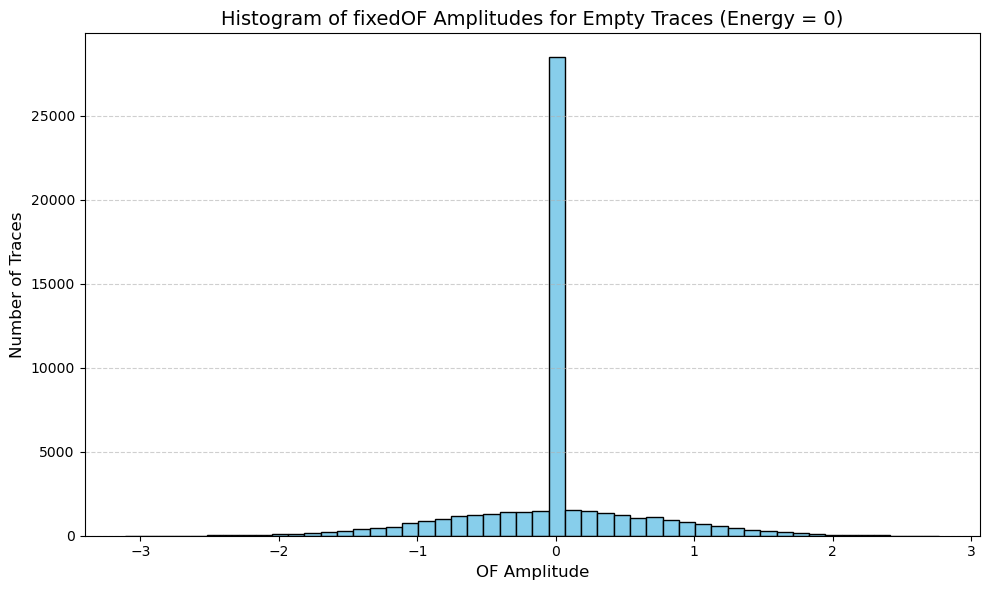

In [26]:
import matplotlib.pyplot as plt
import numpy as np

# Convert to NumPy array if not already
of_amplitudes = np.array(of_amplitudes)

# Define histogram bins
bins = np.linspace(np.min(of_amplitudes), np.max(of_amplitudes), 51)

# Compute histogram
counts, bin_edges = np.histogram(of_amplitudes, bins=bins)

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(bin_edges[:-1], counts, width=np.diff(bin_edges), align='edge',
        color='skyblue', edgecolor='black')

# Styling
plt.xlabel('OF Amplitude', fontsize=12)
plt.ylabel('Number of Traces', fontsize=12)
plt.title('Histogram of fixedOF Amplitudes for Empty Traces (Energy = 0)', fontsize=14)
plt.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


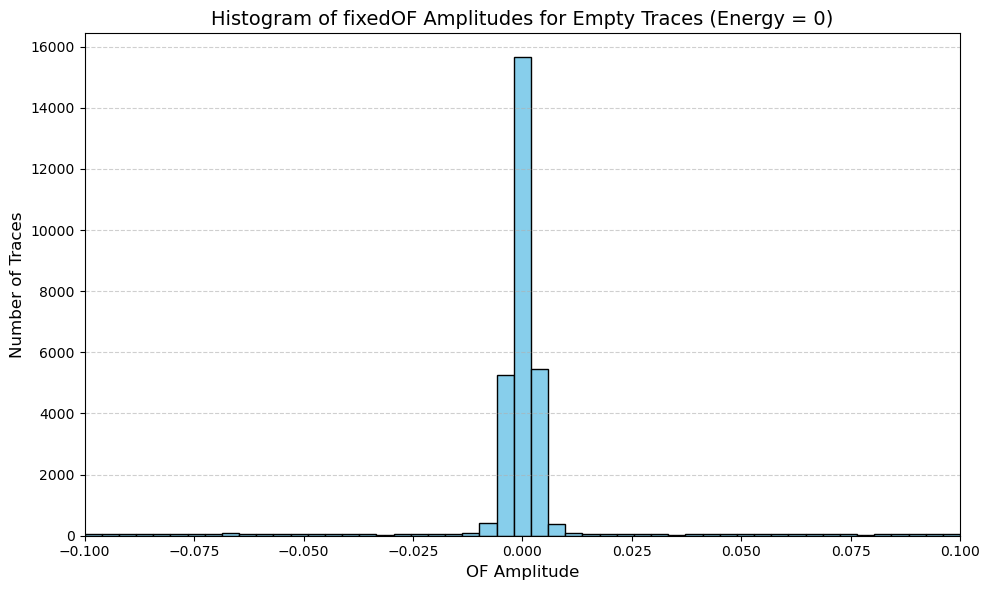

In [32]:
import matplotlib.pyplot as plt
import numpy as np

# Convert to NumPy array if not already
of_amplitudes = np.array(of_amplitudes)

# Define 51 bins between -0.2 and 0.2
bins = np.linspace(-0.1, 0.1, 52)

# Compute histogram
counts, bin_edges = np.histogram(of_amplitudes, bins=bins)

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(bin_edges[:-1], counts, width=np.diff(bin_edges), align='edge',
        color='skyblue', edgecolor='black')

# Styling
plt.xlabel('OF Amplitude', fontsize=12)
plt.ylabel('Number of Traces', fontsize=12)
plt.title('Histogram of fixedOF Amplitudes for Empty Traces (Energy = 0)', fontsize=14)
plt.grid(True, axis='y', linestyle='--', alpha=0.6)

# Set x-axis limit
plt.xlim(-0.1, 0.1)

plt.tight_layout()
plt.show()


In [11]:
counts, bin_edges = np.histogram(of_amplitudes, bins=bins)
print("Total in bins:", np.sum(counts))
print("Total amplitudes:", len(of_amplitudes))
print("Sum of percentages:", np.sum(100 * counts / len(of_amplitudes)))


Total in bins: 53999
Total amplitudes: 54000
Sum of percentages: 99.99814814814815


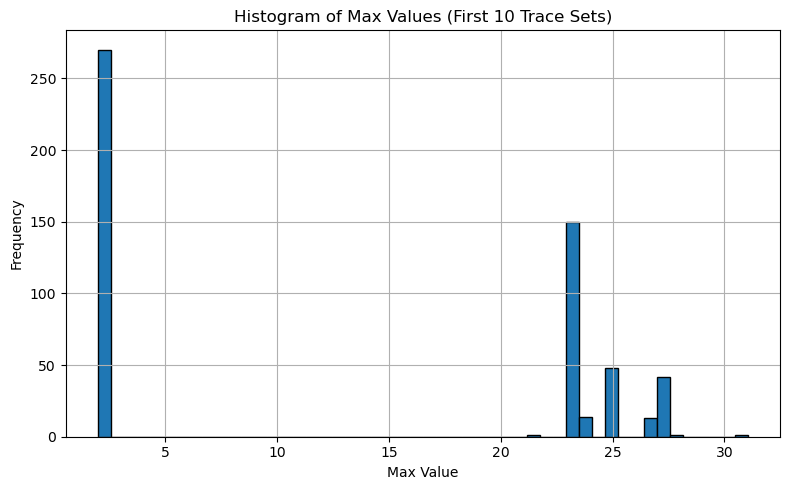

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Parameters
energy = 0
n_sets = 1000
trace_path = f"/ceph/dwong/trigger_samples/traces_energy_{energy}.zst"

# Load traces
loaded_traces = load_traces_from_zstd(trace_path, n_traces=n_sets)

# Collect max values from the first 10 sets
max_vals = []
for i in range(10):
    traces = loaded_traces[i]
    for trace in traces:
        max_vals.append(np.max(trace))

# Convert to numpy array
max_vals = np.array(max_vals)

# Plot histogram
plt.figure(figsize=(8, 5))
plt.hist(max_vals, bins=50, edgecolor='black')
plt.title("Histogram of Max Values (First 10 Trace Sets)")
plt.xlabel("Max Value")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

In [21]:
import numpy as np
from tqdm import tqdm

# Parameters
energy = 0
n_sets = 1000
trace_path = f"/ceph/dwong/trigger_samples/traces_energy_{energy}.zst"

# Load traces
loaded_traces = load_traces_from_zstd(trace_path, n_traces=n_sets)

# Placeholder arrays
of_amplitudes = []
of_t0s = []

# Loop over traces
for i in tqdm(range(n_sets), desc="Computing OF amplitudes and shift times"):
    traces = loaded_traces[i]

    # Compute OF amplitudes and shift times
    results = [trigger.fit_with_shift(trace) for trace in traces]
    amps, _, t0s = zip(*results)

    of_amplitudes.extend(amps)
    of_t0s.extend(t0s)

# Convert to numpy arrays
of_amplitudes = np.array(of_amplitudes)
of_t0s = np.array(of_t0s)


Computing OF amplitudes and shift times: 100%|██████████| 1000/1000 [01:49<00:00,  9.11it/s]


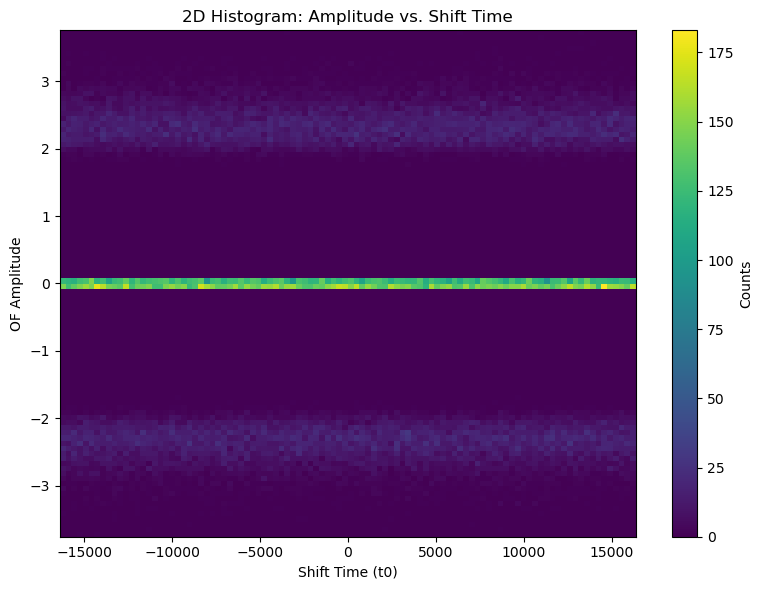

In [22]:
import matplotlib.pyplot as plt

# 2D histogram of amplitude vs. shift time (t0)
plt.figure(figsize=(8, 6))
plt.hist2d(of_t0s, of_amplitudes, bins=[100, 100], cmap='viridis')
plt.colorbar(label='Counts')
plt.xlabel('Shift Time (t0)')
plt.ylabel('OF Amplitude')
plt.title('2D Histogram: Amplitude vs. Shift Time')
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
from tqdm import tqdm

# Parameters
energy = 0
n_sets = 1000
trace_path = f"/ceph/dwong/trigger_samples/traces_energy_{energy}.zst"

# Load traces
loaded_traces = load_traces_from_zstd(trace_path, n_traces=n_sets)

# Placeholder lists
of_amplitudes = []
filtered_traces = []

# Loop over traces
for i in tqdm(range(n_sets), desc="Computing OF and filtering"):
    traces = loaded_traces[i]

    # Compute OF amplitudes for this set
    amps = [trigger.fit(trace)[0] for trace in traces]

    # Store all amplitudes
    of_amplitudes.extend(amps)

    # Filter traces by amplitude threshold
    for amp, trace in zip(amps, traces):
        if amp < 0.02:
            filtered_traces.append(trace)

# Convert to NumPy array (assumes all traces are same length)
filtered_traces = np.array(filtered_traces)
of_amplitudes = np.array(of_amplitudes)

# Save to NPZ
np.savez_compressed("low_amplitude_traces.npz", traces=filtered_traces, amplitudes=of_amplitudes[of_amplitudes < 0.02])


Computing OF and filtering: 100%|██████████| 1000/1000 [01:00<00:00, 16.49it/s]


In [34]:
np.savez_compressed("low_amplitude_traces.npz", traces=filtered_traces, amplitudes=of_amplitudes[of_amplitudes < 0.02])


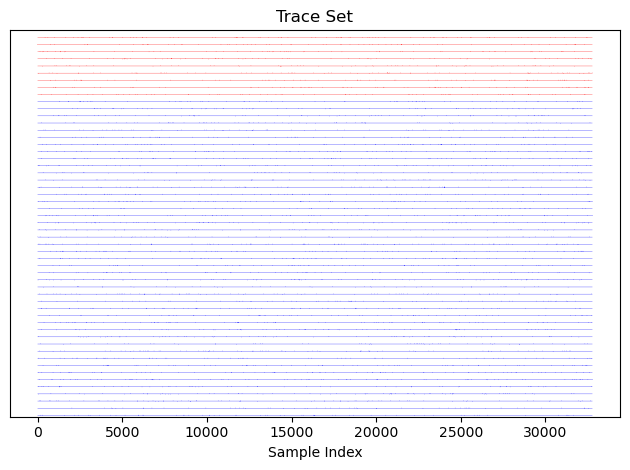

In [35]:
plot_trace_set(filtered_traces[:54])

In [ ]:
import numpy as np
from tqdm import tqdm

# Assume filtered_traces is already defined and has shape (40839, 32768)
n_traces = filtered_traces.shape[0]

# Allocate arrays for fit results
of_amplitudes = np.empty(n_traces)
chi2_values = np.empty(n_traces)
t0_values = np.empty(n_traces)

# Loop over each trace and compute fit parameters
for i in tqdm(range(n_traces), desc="Fitting traces"):
    trace = filtered_traces[i]
    amp, chi2, t0 = trigger.fit_with_shift(trace)  # Assumes this returns a tuple of 3 values
    of_amplitudes[i] = amp
    chi2_values[i] = chi2
    t0_values[i] = t0




Fitting traces: 100%|██████████| 40839/40839 [01:24<00:00, 481.76it/s]


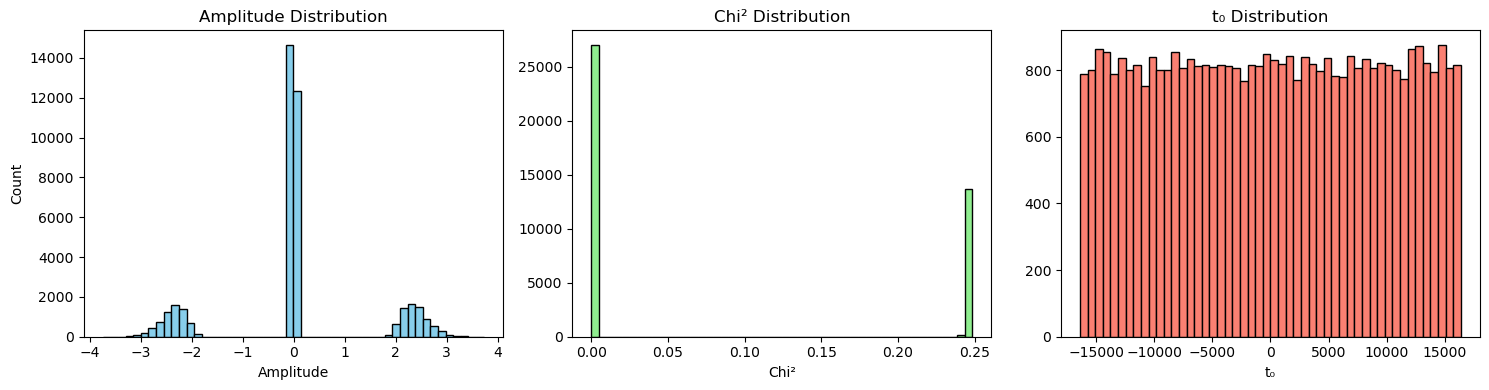

In [40]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 4))

# Amplitude histogram
plt.subplot(1, 3, 1)
plt.hist(of_amplitudes, bins=50, color='skyblue', edgecolor='black')
plt.title("Amplitude Distribution")
plt.xlabel("Amplitude")
plt.ylabel("Count")

# Chi² histogram
plt.subplot(1, 3, 2)
plt.hist(chi2_values, bins=50, color='lightgreen', edgecolor='black')
plt.title("Chi² Distribution")
plt.xlabel("Chi²")

# t₀ histogram
plt.subplot(1, 3, 3)
plt.hist(t0_values, bins=50, color='salmon', edgecolor='black')
plt.title("t₀ Distribution")
plt.xlabel("t₀")

plt.tight_layout()
plt.show()


In [42]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Fit results storage
n_traces = 20  # or use filtered_traces.shape[0] for all
fit_results = []

# Loop over traces and apply both fit and fit_with_shift
for i in tqdm(range(n_traces), desc="Fitting with and without shift"):
    trace = filtered_traces[i]

    # Fit without shift
    amp1, chi2_1 = trigger.fit(trace)

    # Fit with shift
    amp2, chi2_2, t0_2 = trigger.fit_with_shift(trace)

    # Store results
    fit_results.append({
        "index": i,
        "trace": trace,
        "amp_no_shift": amp1,
        "chi2_no_shift": chi2_1,
        "amp_shift": amp2,
        "chi2_shift": chi2_2,
        "t0_shift": t0_2,
    })


Fitting with and without shift: 100%|██████████| 20/20 [00:00<00:00, 429.39it/s]


Fitting and plotting:   0%|          | 0/20 [00:00<?, ?it/s]

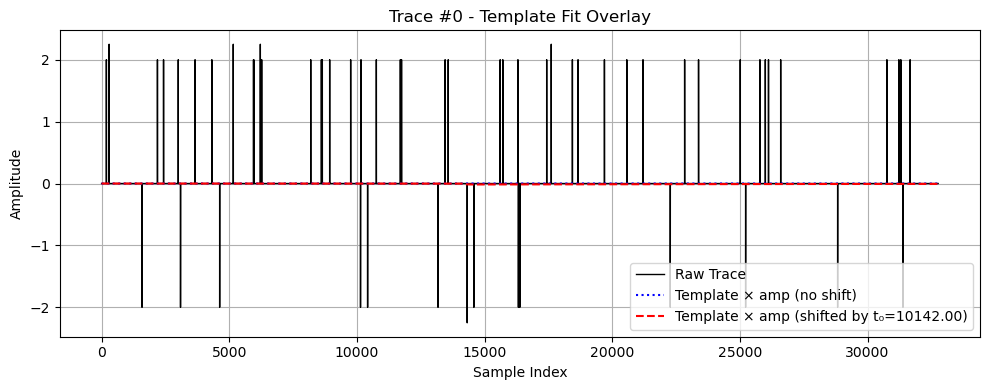

Fitting and plotting:   5%|▌         | 1/20 [00:00<00:15,  1.21it/s]

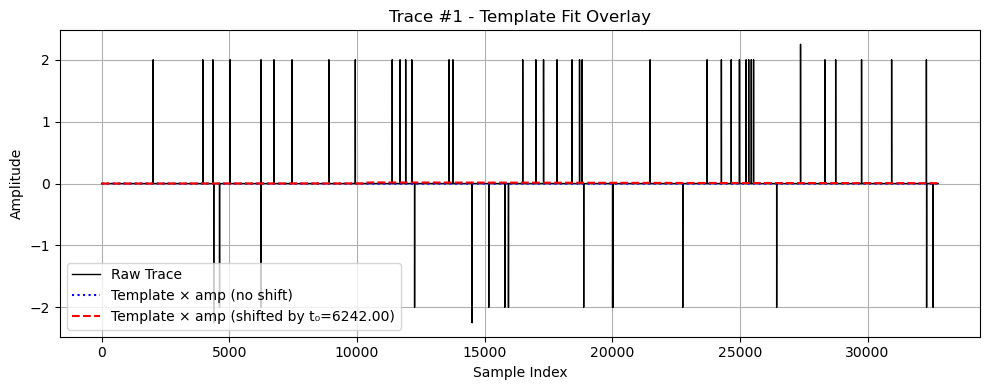

Fitting and plotting:  10%|█         | 2/20 [00:01<00:14,  1.28it/s]

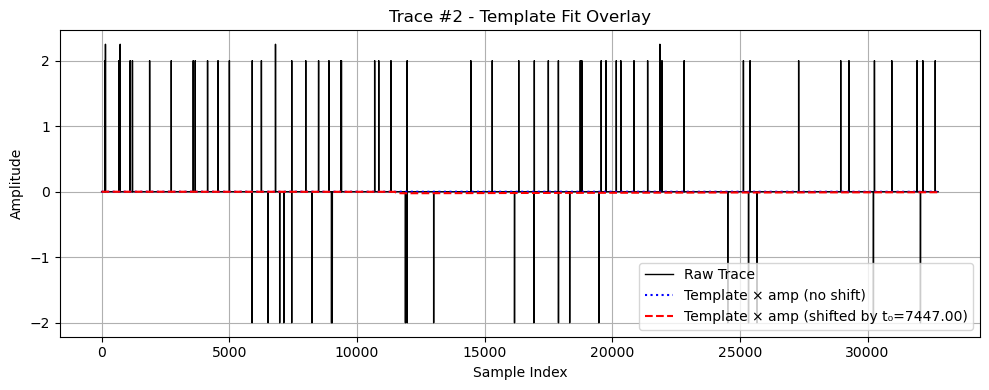

Fitting and plotting:  15%|█▌        | 3/20 [00:02<00:12,  1.36it/s]

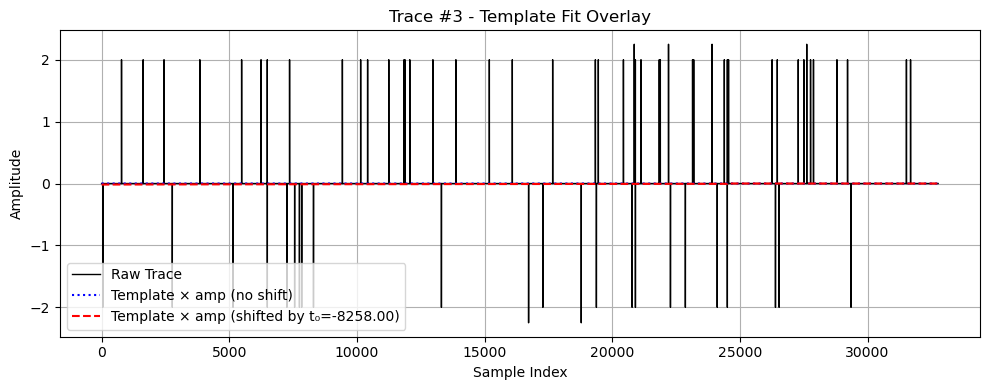

Fitting and plotting:  20%|██        | 4/20 [00:02<00:11,  1.40it/s]

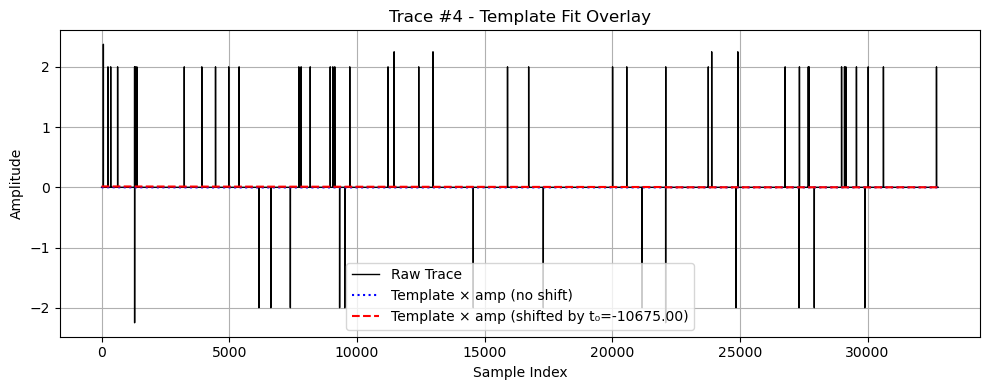

Fitting and plotting:  25%|██▌       | 5/20 [00:03<00:10,  1.43it/s]

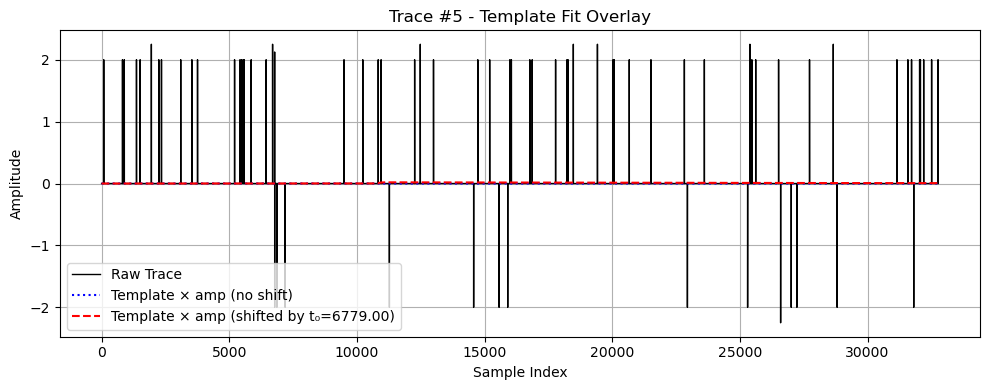

Fitting and plotting:  30%|███       | 6/20 [00:04<00:09,  1.50it/s]

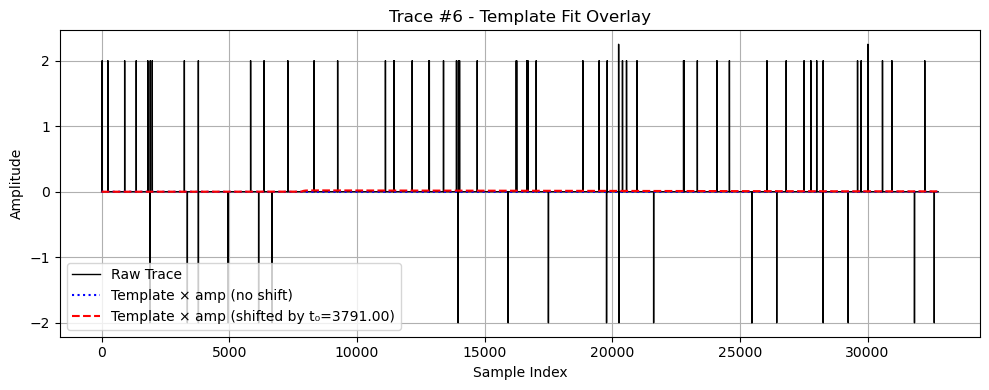

Fitting and plotting:  35%|███▌      | 7/20 [00:05<00:09,  1.38it/s]

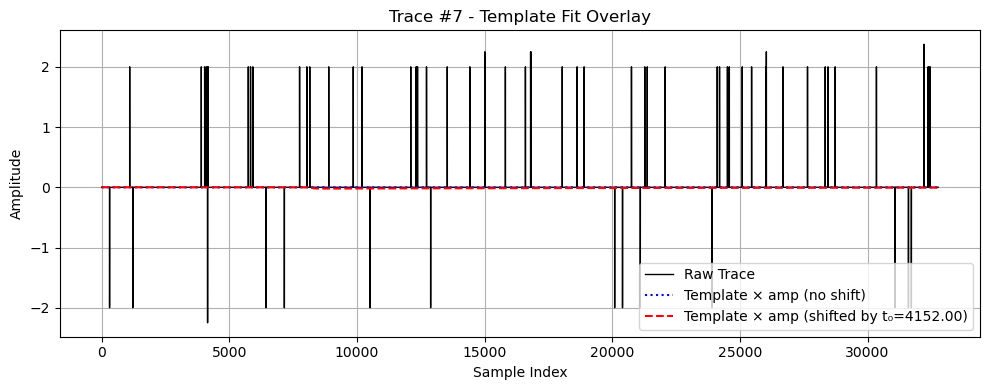

Fitting and plotting:  40%|████      | 8/20 [00:05<00:09,  1.30it/s]

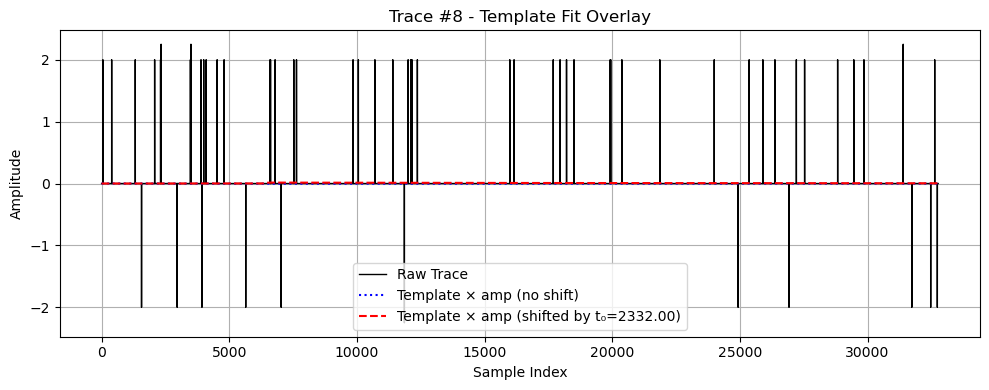

Fitting and plotting:  45%|████▌     | 9/20 [00:06<00:08,  1.28it/s]

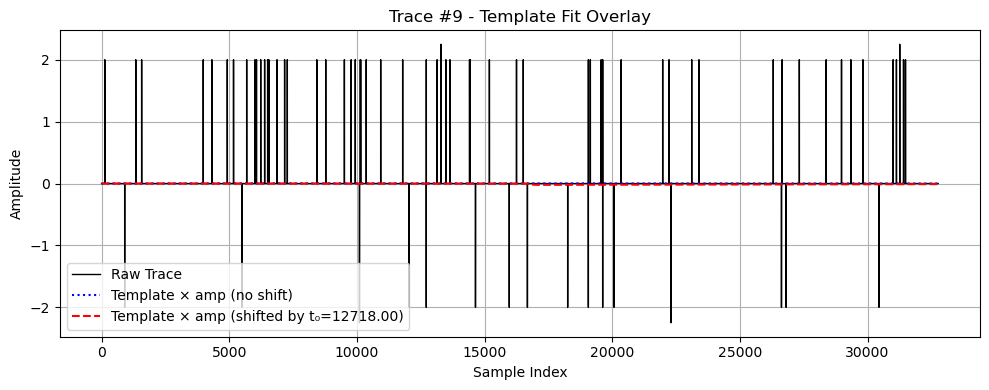

Fitting and plotting:  50%|█████     | 10/20 [00:07<00:07,  1.40it/s]

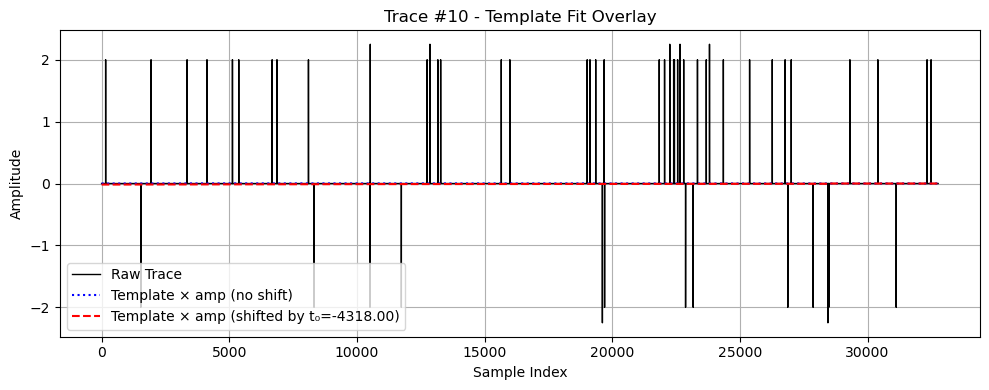

Fitting and plotting:  55%|█████▌    | 11/20 [00:07<00:06,  1.49it/s]

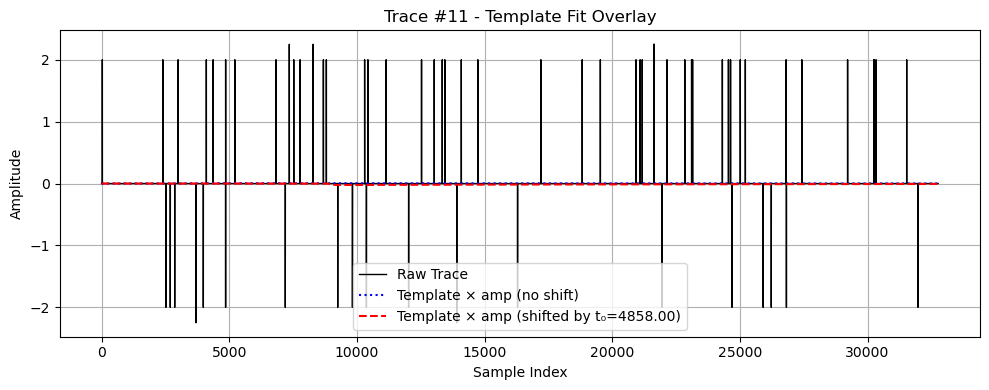

Fitting and plotting:  60%|██████    | 12/20 [00:08<00:05,  1.55it/s]

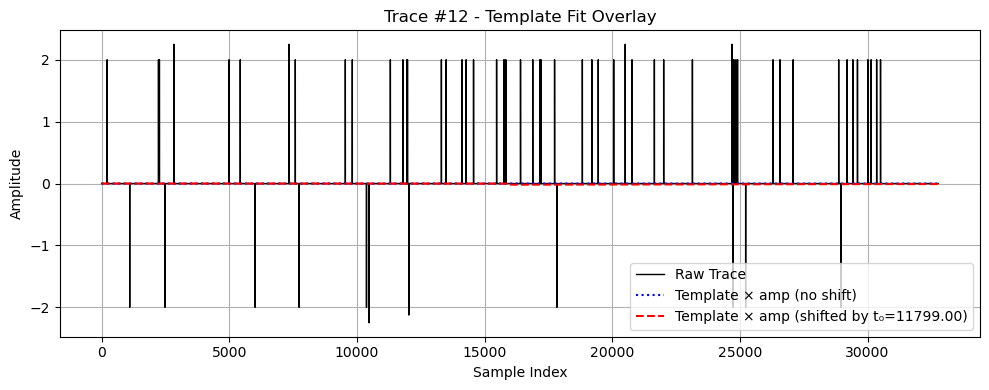

Fitting and plotting:  65%|██████▌   | 13/20 [00:08<00:04,  1.64it/s]

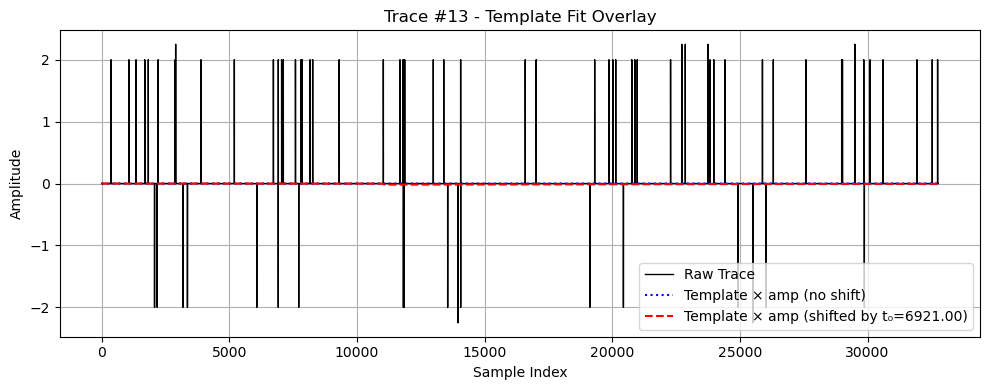

Fitting and plotting:  70%|███████   | 14/20 [00:09<00:03,  1.67it/s]

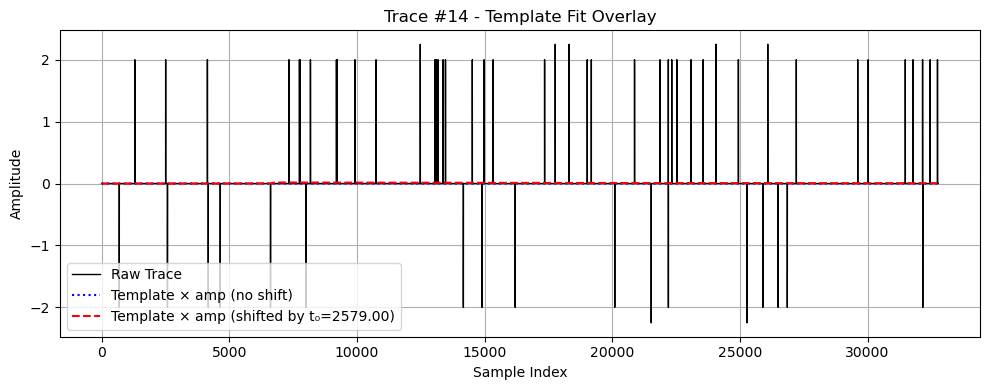

Fitting and plotting:  75%|███████▌  | 15/20 [00:10<00:02,  1.69it/s]

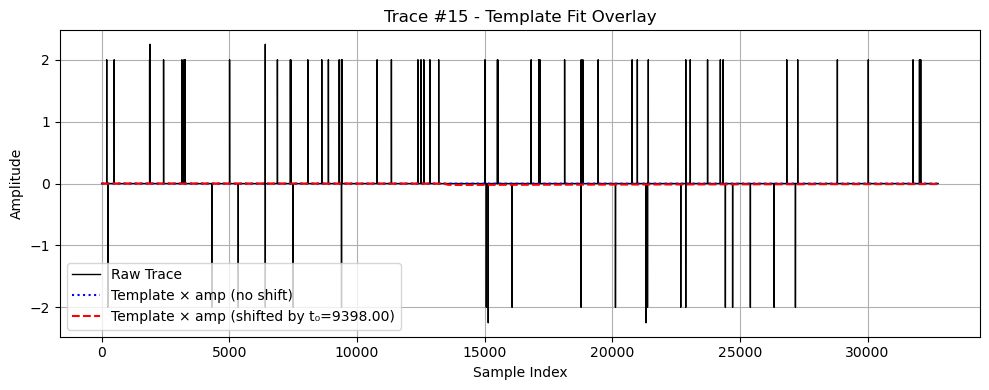

Fitting and plotting:  80%|████████  | 16/20 [00:10<00:02,  1.68it/s]

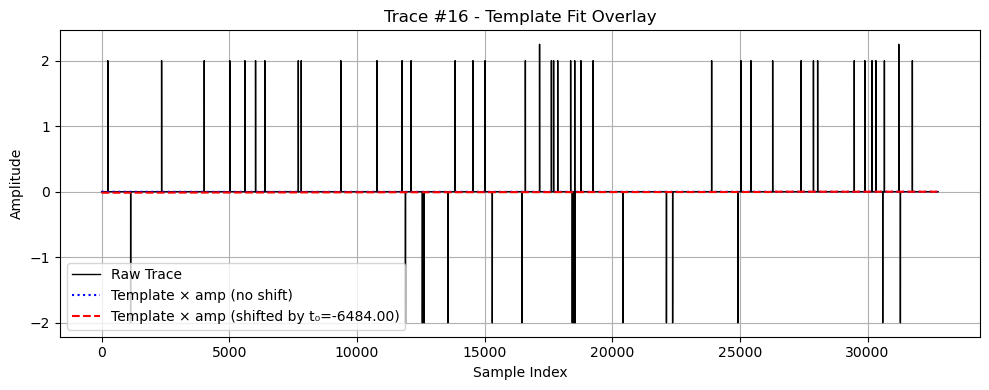

Fitting and plotting:  85%|████████▌ | 17/20 [00:11<00:01,  1.67it/s]

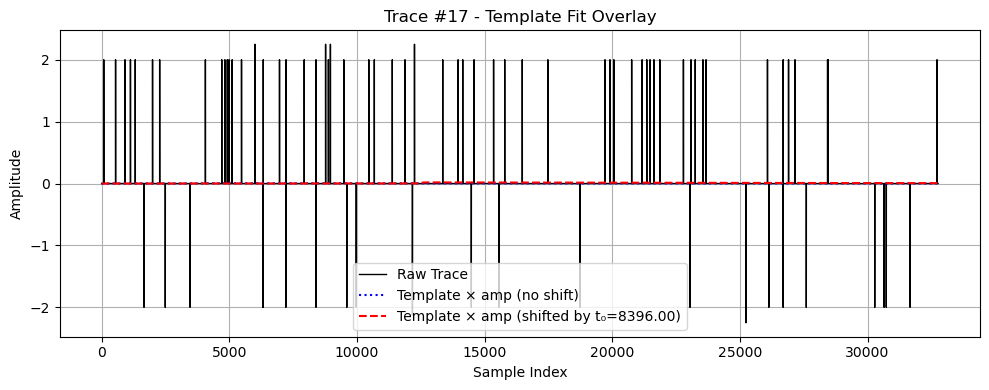

Fitting and plotting:  90%|█████████ | 18/20 [00:11<00:01,  1.67it/s]

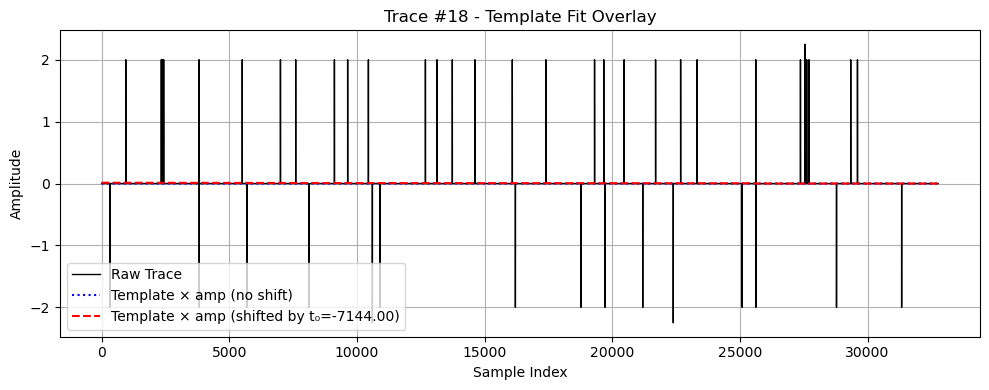

Fitting and plotting:  95%|█████████▌| 19/20 [00:12<00:00,  1.70it/s]

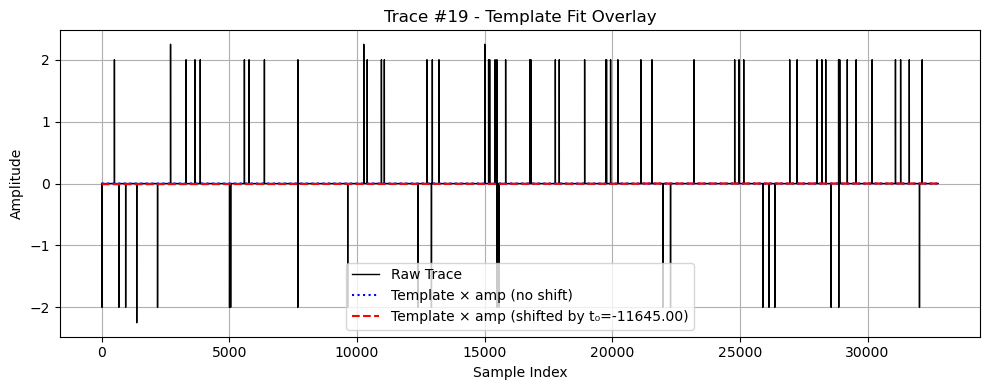

Fitting and plotting: 100%|██████████| 20/20 [00:13<00:00,  1.53it/s]


In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from tqdm import tqdm

# Load traces from .npz file
data = np.load("low_amplitude_traces.npz")
filtered_traces = data["traces"]  # adjust key if needed, e.g., data['arr_0']

# Load your template
template = np.load("../templates/template_K_alpha_no_baseline.npy")

# Fit and plot first N traces
n_traces = 20
x_template = np.arange(len(template))

for i in tqdm(range(n_traces), desc="Fitting and plotting"):
    trace = filtered_traces[i]

    # Fit without shift
    amp1, chi2_1 = trigger.fit(trace)

    # Fit with shift
    amp2, chi2_2, t0_2 = trigger.fit_with_shift(trace)

    # Interpolate and shift template by t0_2, and rescale by amp2
    interp_func = interp1d(x_template, template, kind='linear', fill_value=0, bounds_error=False)
    shifted_template = interp_func(x_template - t0_2) * amp2

    # Plot
    plt.figure(figsize=(10, 4))
    plt.plot(trace, label="Raw Trace", color="black", linewidth=1)
    plt.plot(x_template, template * amp1, label="Template × amp (no shift)", color="blue", linestyle=":")
    plt.plot(x_template, shifted_template, label=f"Template × amp (shifted by t₀={t0_2:.2f})", color="red", linestyle="--")

    plt.title(f"Trace #{i} - Template Fit Overlay")
    plt.xlabel("Sample Index")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


Fitting and plotting:  51%|█████     | 51/100 [00:00<00:00, 194.90it/s]

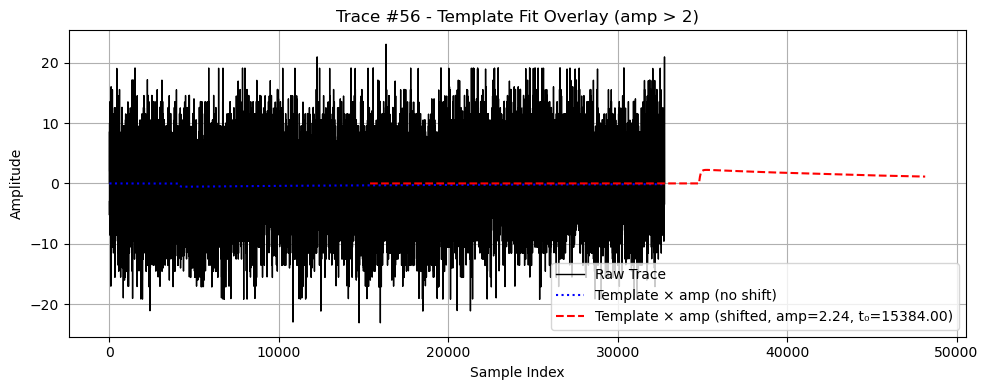

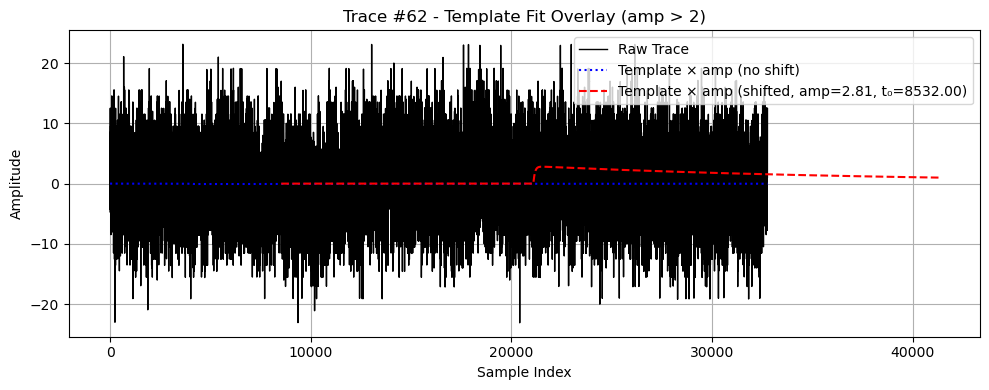

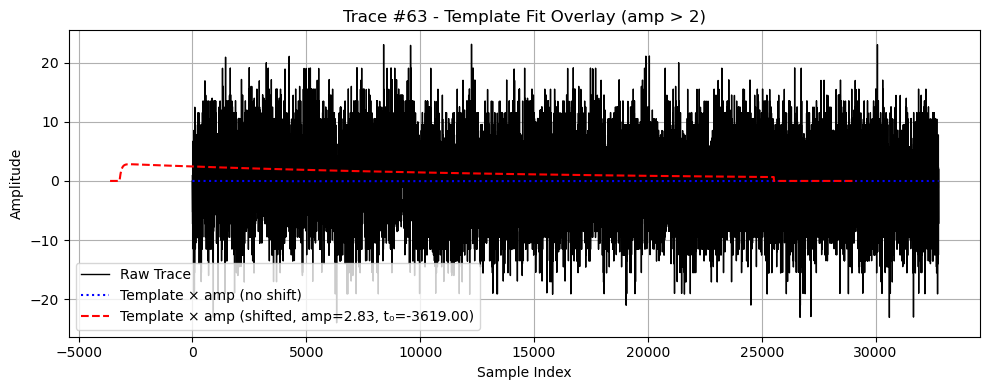

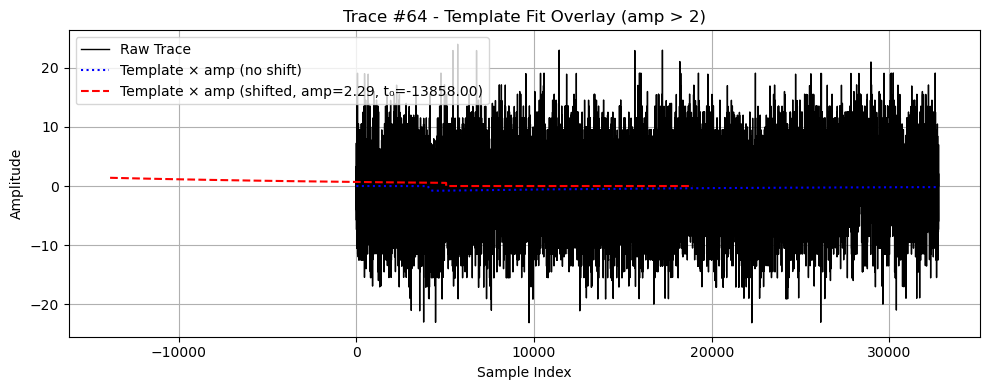

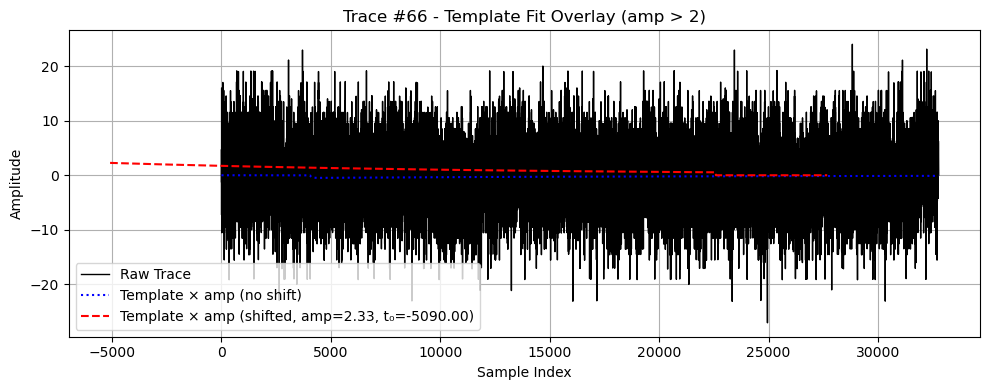

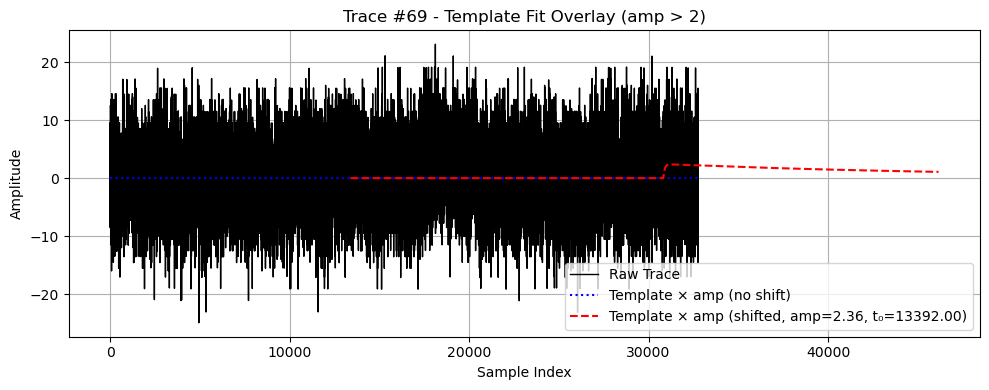

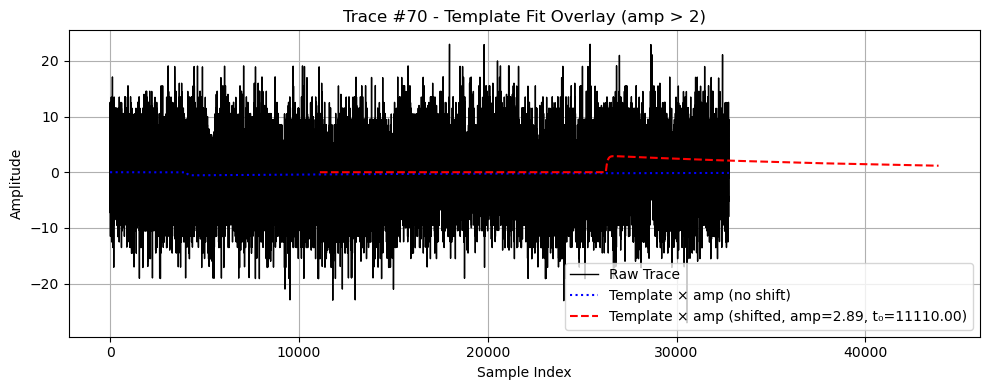

Fitting and plotting:  71%|███████   | 71/100 [00:05<00:03,  9.42it/s] 

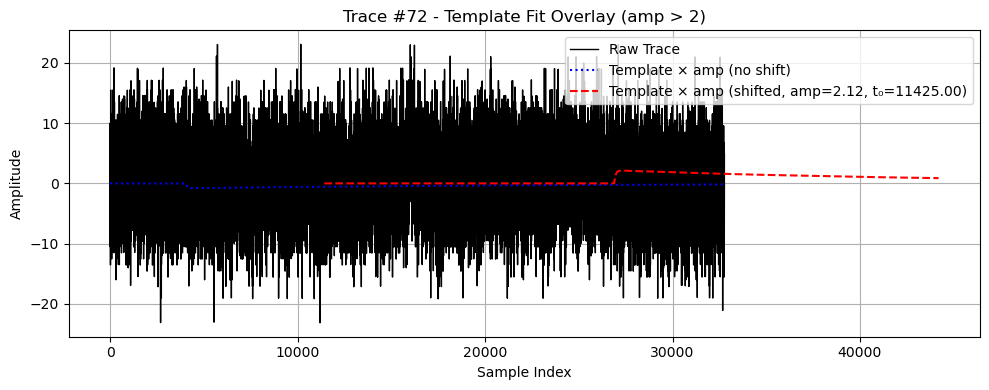

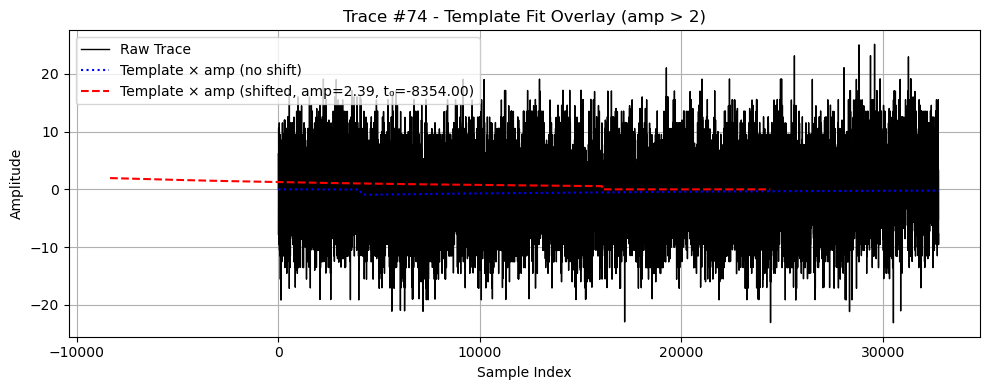

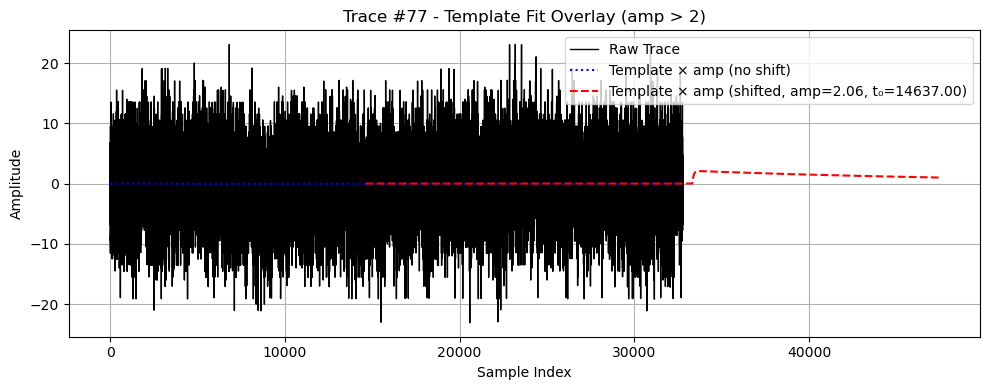

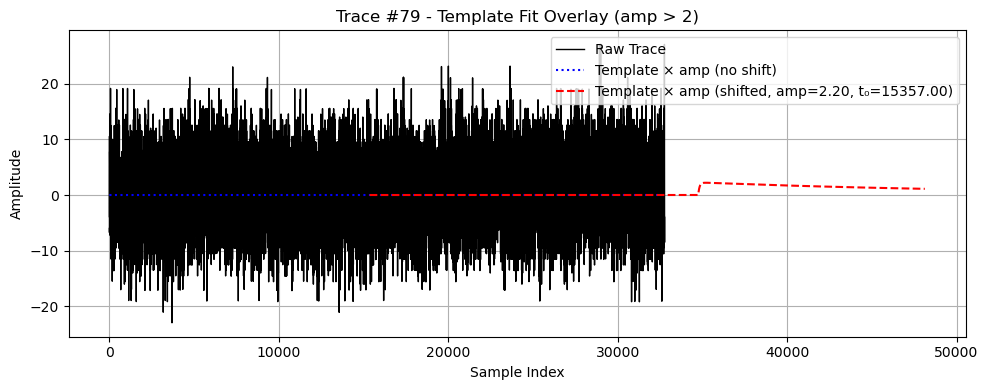

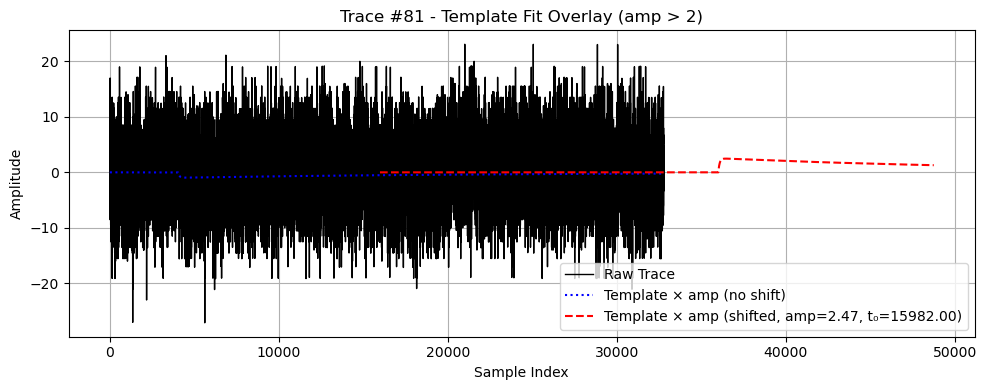

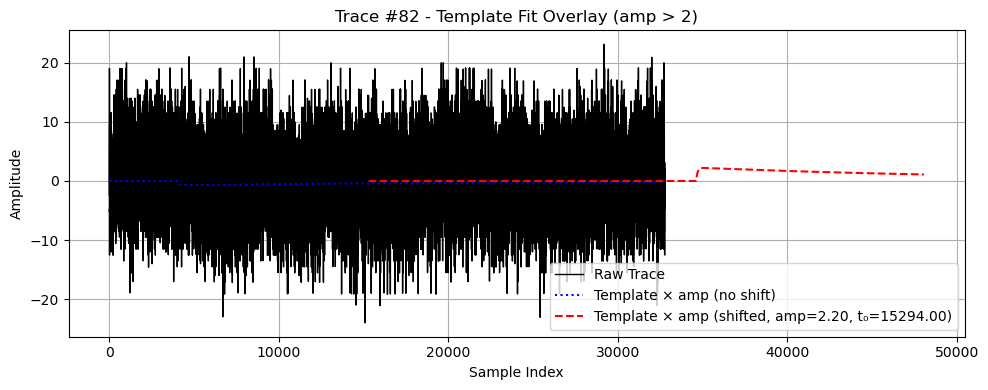

Fitting and plotting: 100%|██████████| 100/100 [00:10<00:00,  9.82it/s]


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from tqdm import tqdm

# Load traces from .npz file
data = np.load("low_amplitude_traces.npz")
filtered_traces = data["traces"]  # adjust key if needed

# Load your template
template = np.load("../templates/template_K_alpha_no_baseline.npy")

# Fit and plot first N traces that pass the amp2 > 2 condition
n_traces_to_check = 100  # check up to this many traces
x_template = np.arange(len(template))

for i in tqdm(range(n_traces_to_check), desc="Fitting and plotting"):
    trace = filtered_traces[i]

    # Fit without shift
    amp1, chi2_1 = trigger.fit(trace)

    # Fit with shift
    amp2, chi2_2, t0_2 = trigger.fit_with_shift(trace)

    # Only plot if amp2 > 2
    if amp2 > 2:
        # Interpolate and shift template by t0_2, and rescale by amp2
        interp_func = interp1d(x_template, template, kind='linear', fill_value=0, bounds_error=False)
        shifted_template = interp_func(x_template - t0_2) * amp2
        shifted_x = x_template + t0_2  # shift x-axis too

        # Plot
        plt.figure(figsize=(10, 4))
        plt.plot(trace, label="Raw Trace", color="black", linewidth=1)
        plt.plot(x_template, template * amp1, label="Template × amp (no shift)", color="blue", linestyle=":")
        plt.plot(shifted_x, shifted_template, label=f"Template × amp (shifted, amp={amp2:.2f}, t₀={t0_2:.2f})", color="red", linestyle="--")

        plt.title(f"Trace #{i} - Template Fit Overlay (amp > 2)")
        plt.xlabel("Sample Index")
        plt.ylabel("Amplitude")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()


Fitting and plotting:   0%|          | 0/50 [00:00<?, ?it/s]

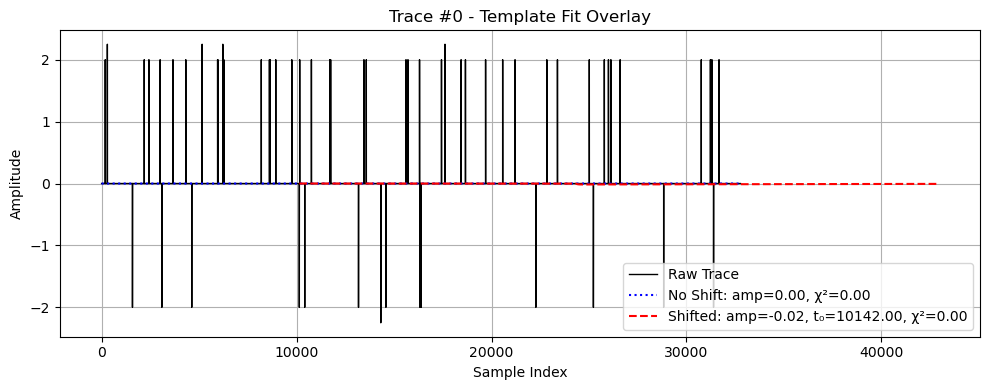

Fitting and plotting:   2%|▏         | 1/50 [00:00<00:26,  1.85it/s]

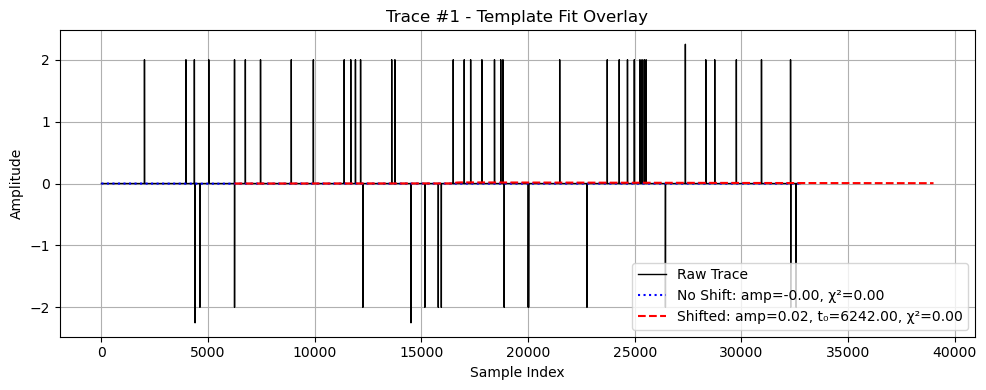

Fitting and plotting:   4%|▍         | 2/50 [00:01<00:27,  1.77it/s]

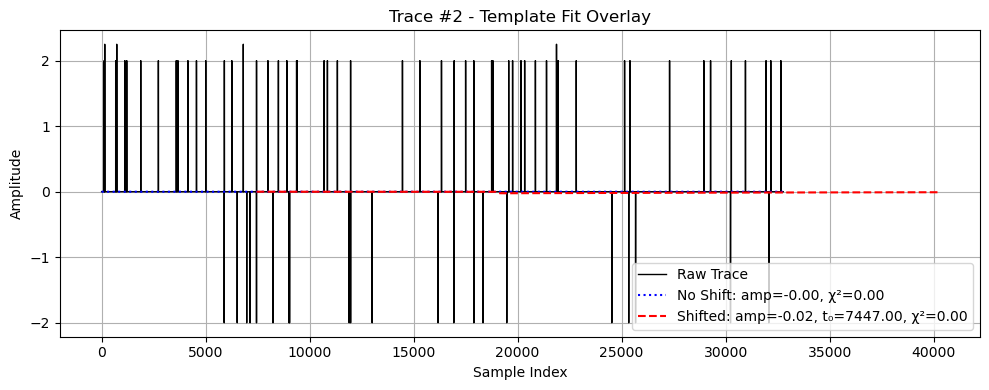

Fitting and plotting:   6%|▌         | 3/50 [00:01<00:25,  1.84it/s]

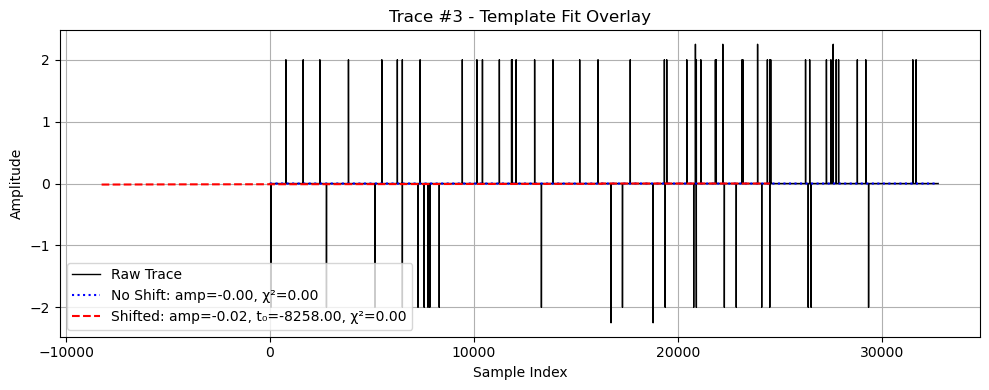

Fitting and plotting:   8%|▊         | 4/50 [00:02<00:24,  1.90it/s]

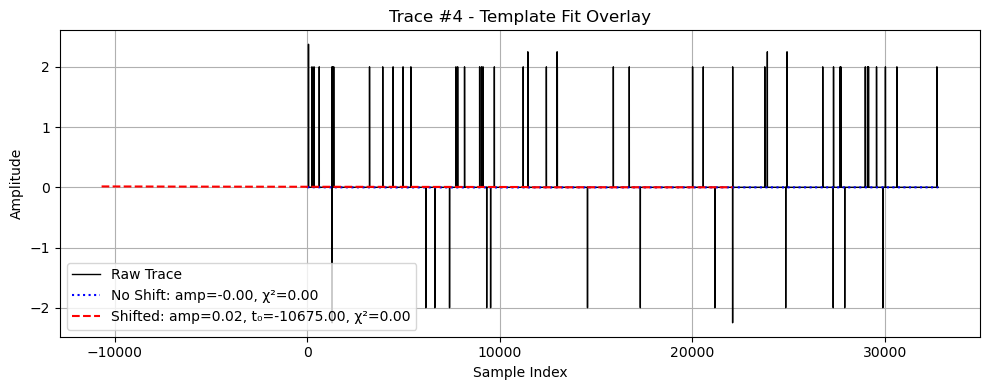

Fitting and plotting:  10%|█         | 5/50 [00:02<00:23,  1.94it/s]

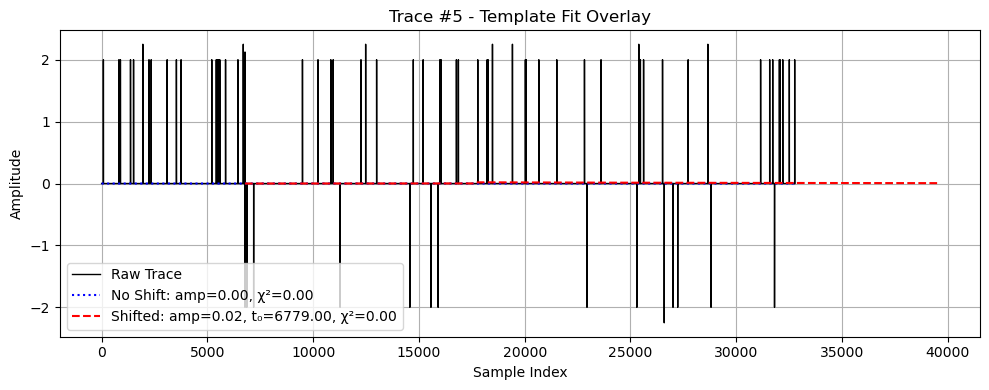

Fitting and plotting:  12%|█▏        | 6/50 [00:03<00:22,  1.92it/s]

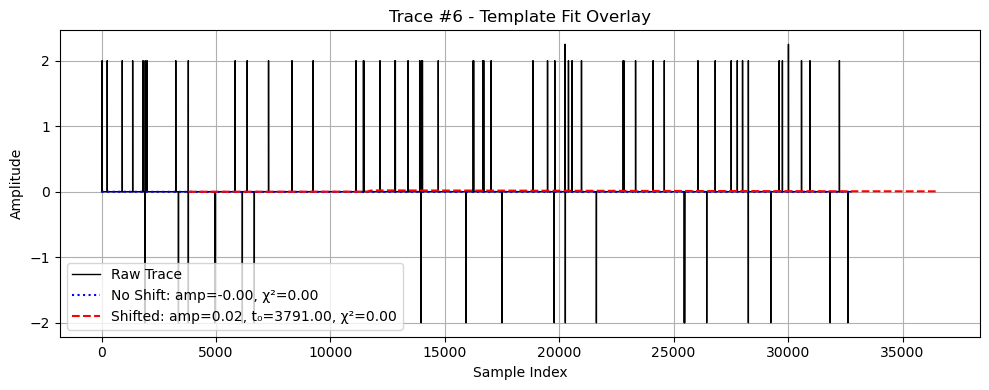

Fitting and plotting:  14%|█▍        | 7/50 [00:03<00:22,  1.93it/s]

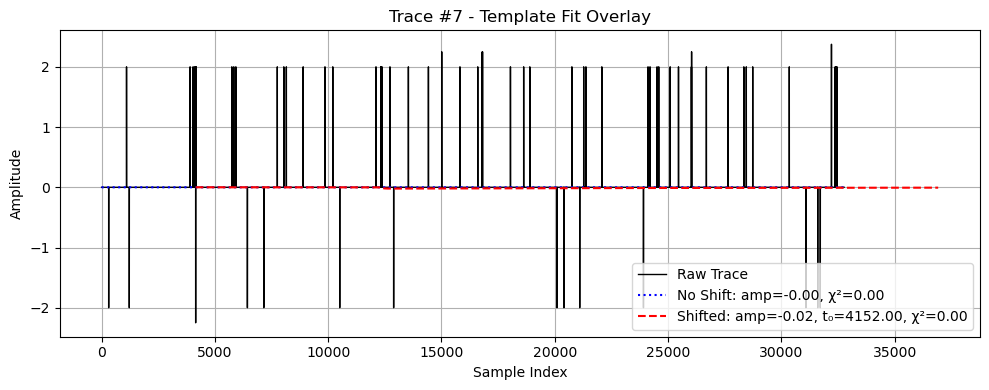

Fitting and plotting:  16%|█▌        | 8/50 [00:04<00:21,  1.92it/s]

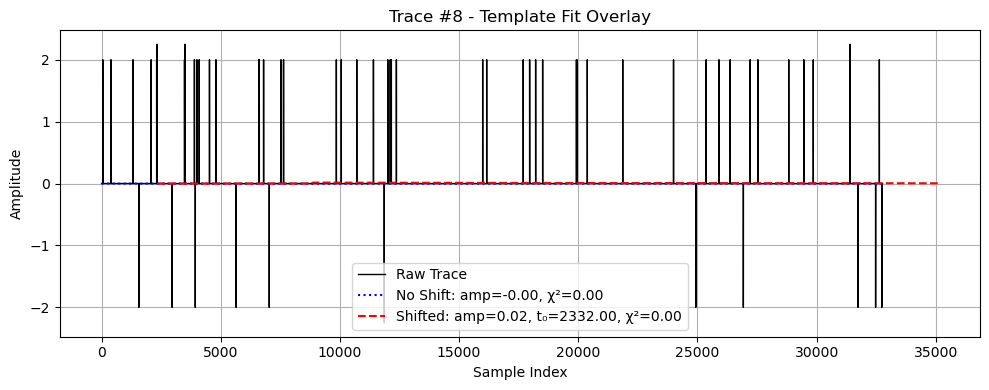

Fitting and plotting:  18%|█▊        | 9/50 [00:04<00:21,  1.91it/s]

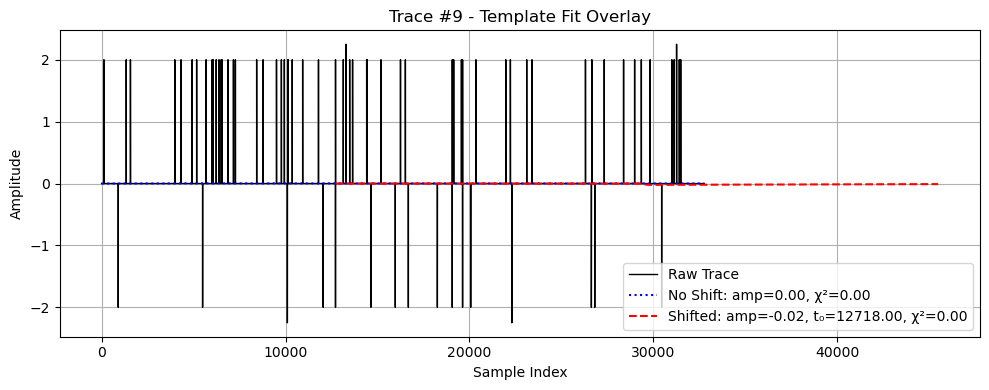

Fitting and plotting:  20%|██        | 10/50 [00:05<00:21,  1.88it/s]

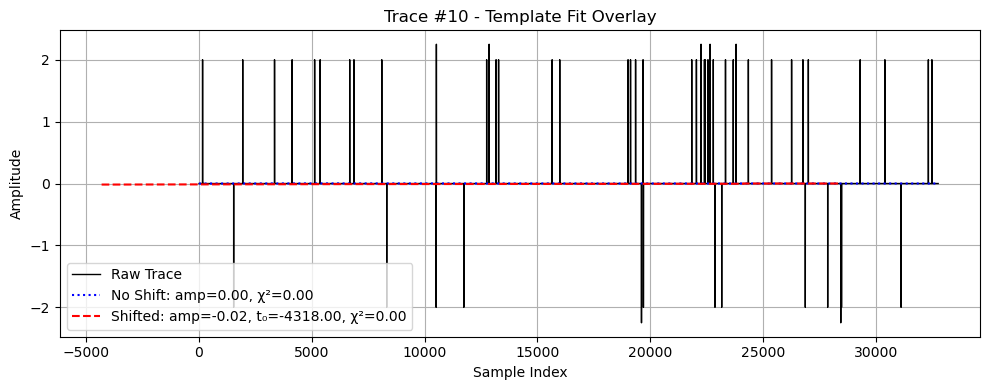

Fitting and plotting:  22%|██▏       | 11/50 [00:05<00:20,  1.88it/s]

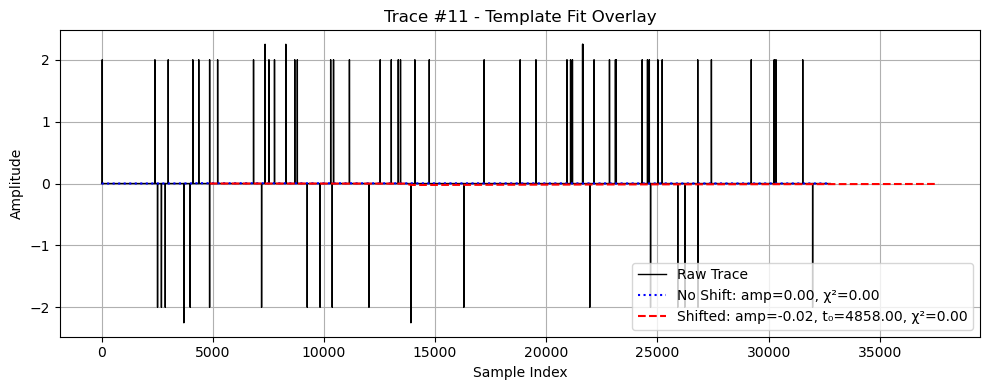

Fitting and plotting:  24%|██▍       | 12/50 [00:06<00:20,  1.88it/s]

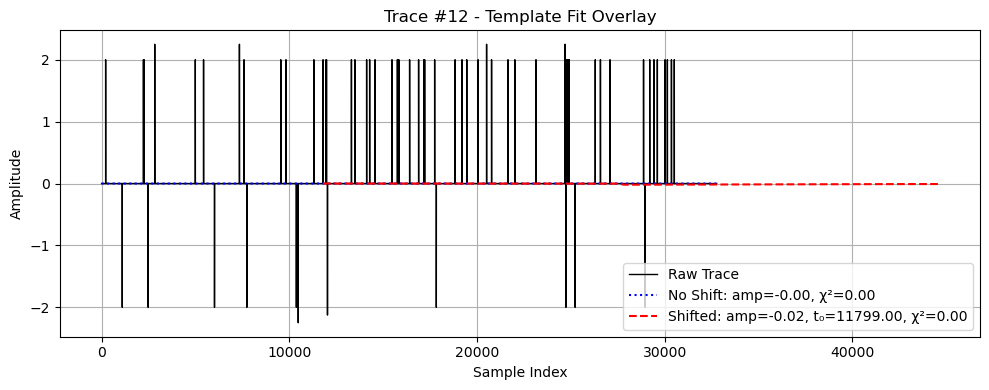

Fitting and plotting:  26%|██▌       | 13/50 [00:07<00:21,  1.74it/s]

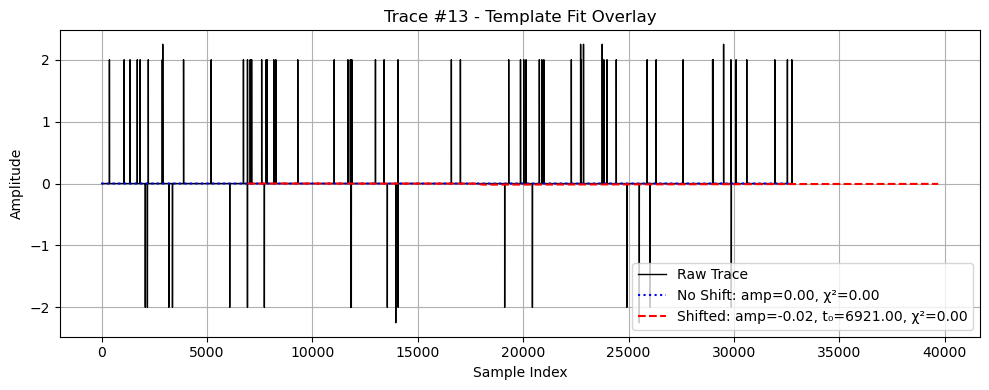

Fitting and plotting:  28%|██▊       | 14/50 [00:07<00:20,  1.78it/s]

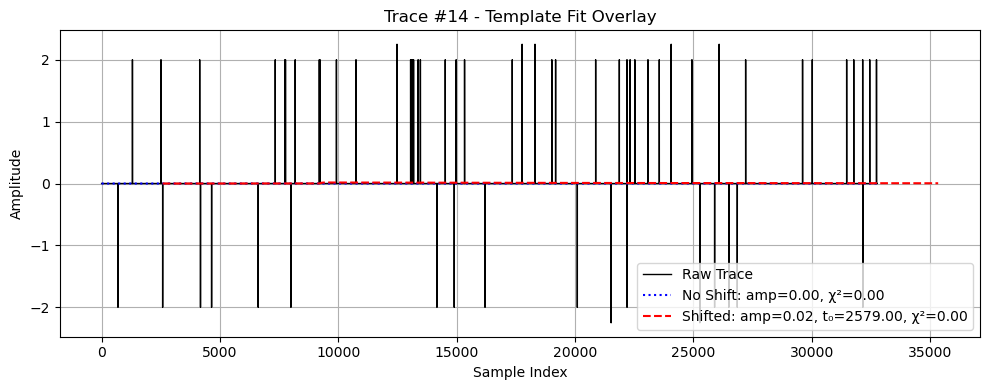

Fitting and plotting:  30%|███       | 15/50 [00:08<00:19,  1.83it/s]

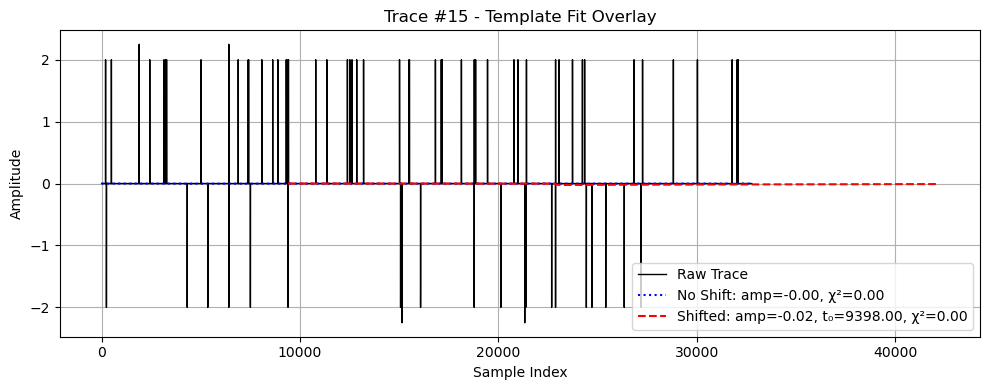

Fitting and plotting:  32%|███▏      | 16/50 [00:08<00:18,  1.87it/s]

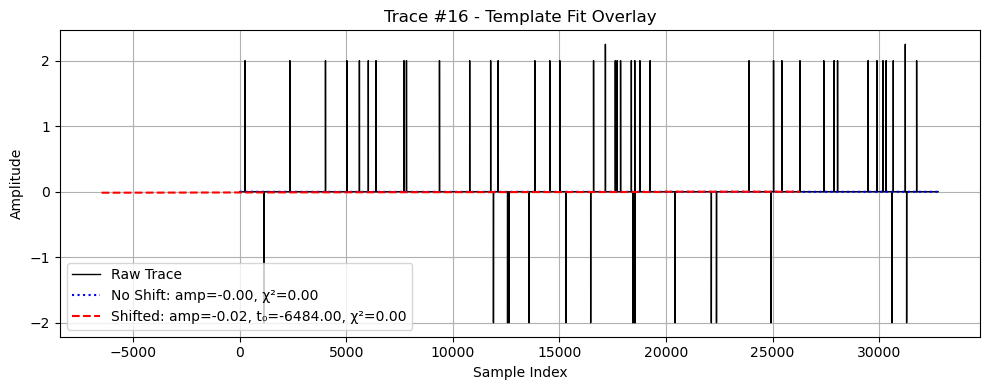

Fitting and plotting:  34%|███▍      | 17/50 [00:09<00:17,  1.89it/s]

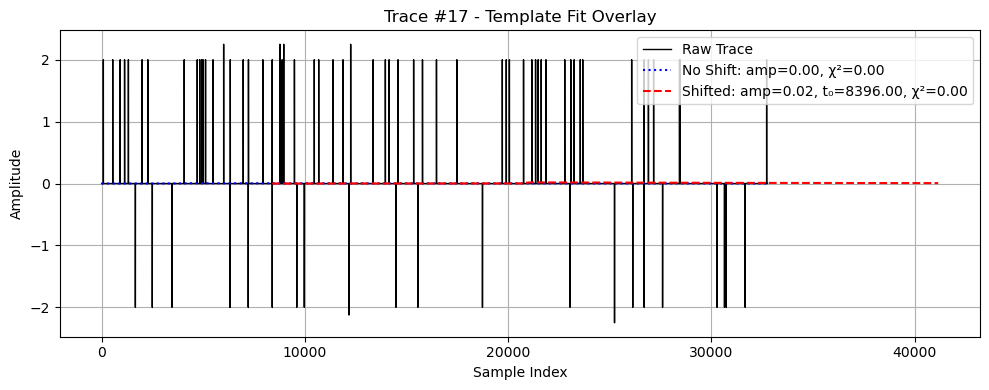

Fitting and plotting:  36%|███▌      | 18/50 [00:09<00:16,  1.91it/s]

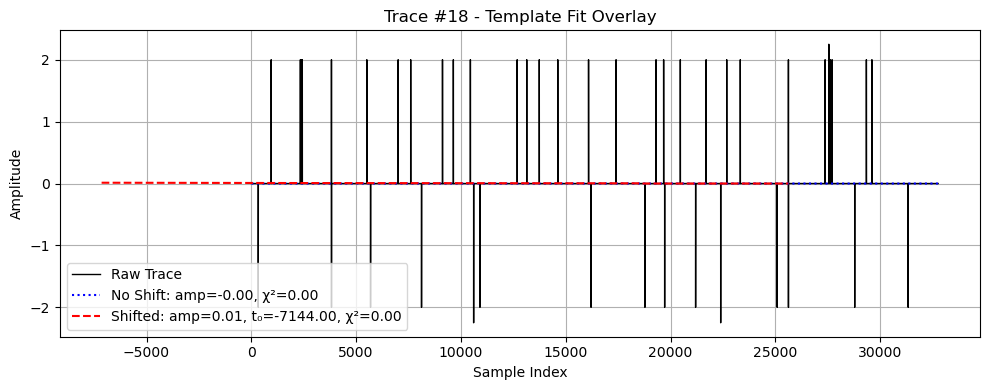

Fitting and plotting:  38%|███▊      | 19/50 [00:10<00:16,  1.93it/s]

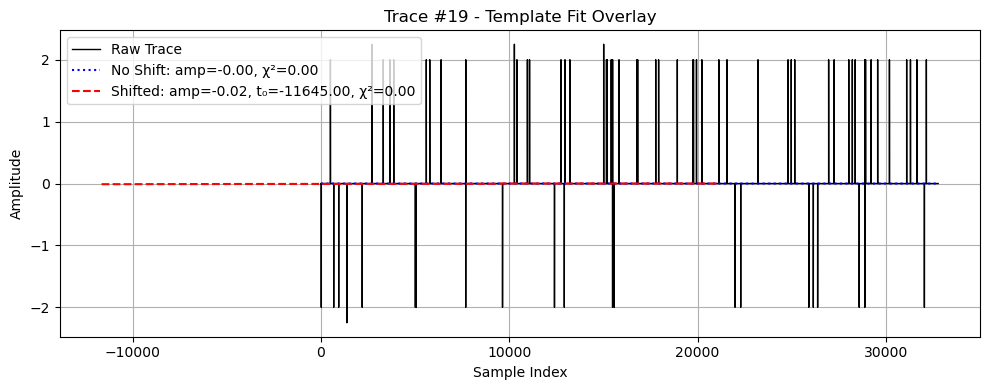

Fitting and plotting:  40%|████      | 20/50 [00:10<00:15,  1.96it/s]

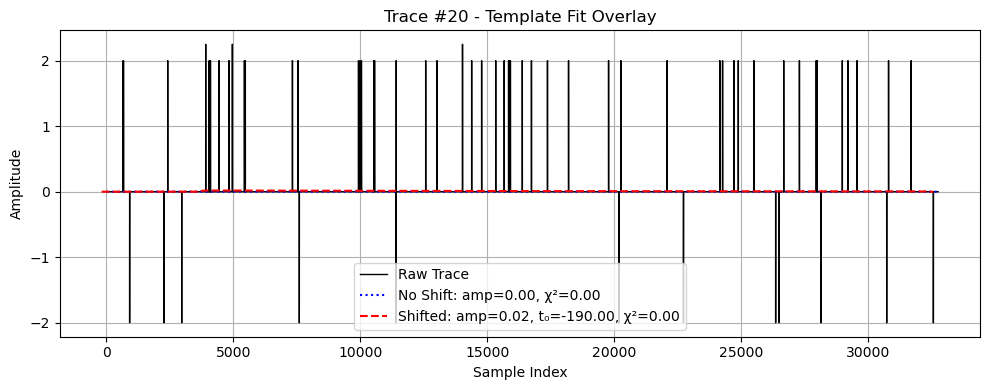

Fitting and plotting:  42%|████▏     | 21/50 [00:11<00:15,  1.91it/s]

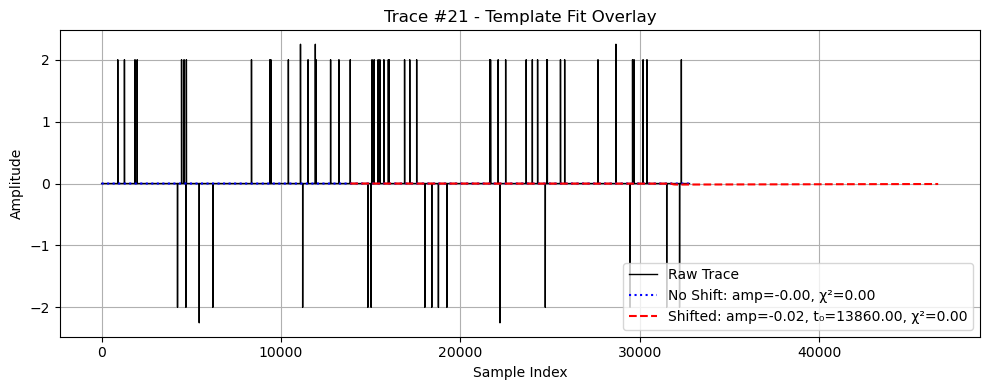

Fitting and plotting:  44%|████▍     | 22/50 [00:11<00:14,  1.91it/s]

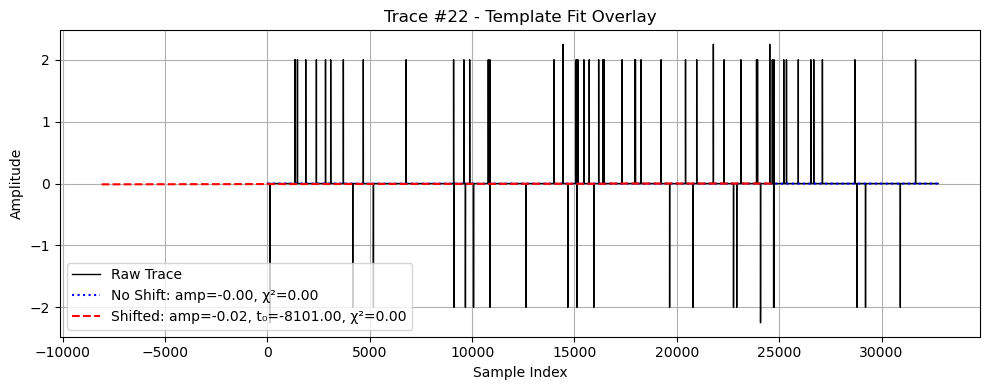

Fitting and plotting:  46%|████▌     | 23/50 [00:12<00:14,  1.90it/s]

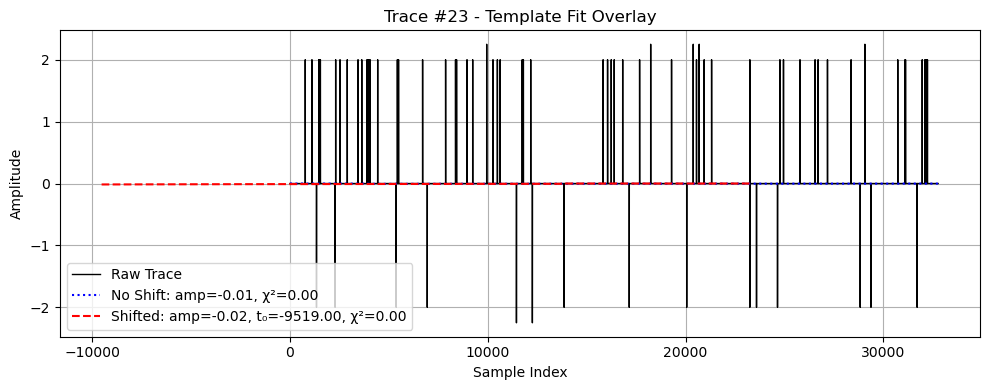

Fitting and plotting:  48%|████▊     | 24/50 [00:12<00:13,  1.93it/s]

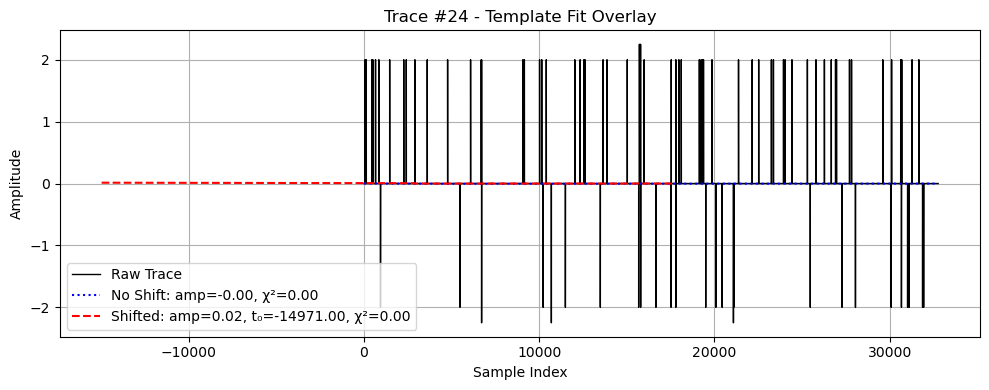

Fitting and plotting:  50%|█████     | 25/50 [00:13<00:12,  1.95it/s]

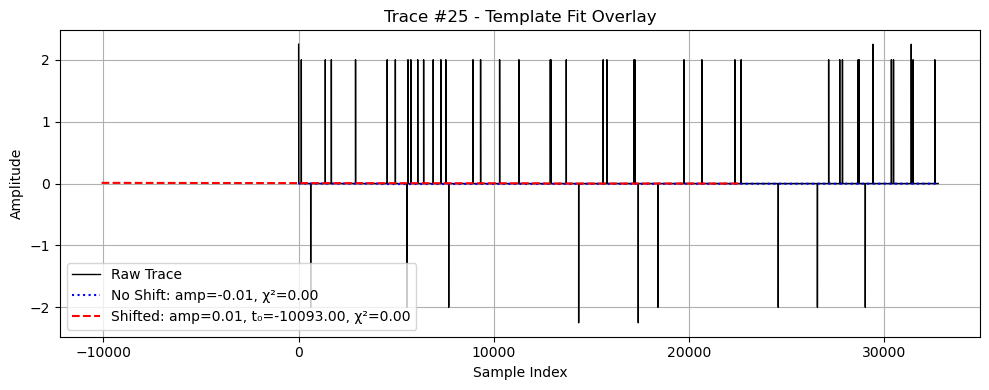

Fitting and plotting:  52%|█████▏    | 26/50 [00:13<00:12,  1.96it/s]

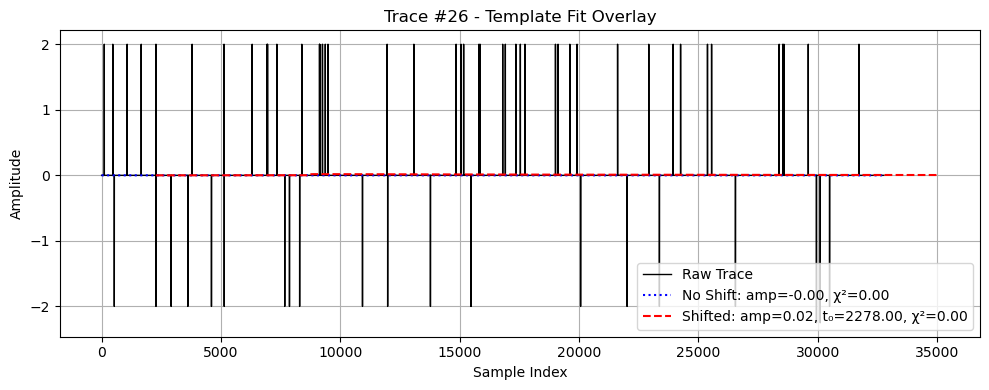

Fitting and plotting:  54%|█████▍    | 27/50 [00:14<00:11,  1.95it/s]

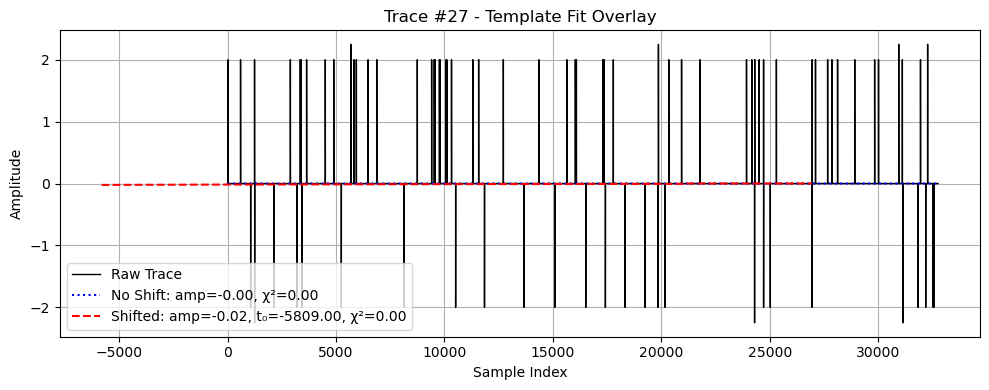

Fitting and plotting:  56%|█████▌    | 28/50 [00:14<00:11,  1.95it/s]

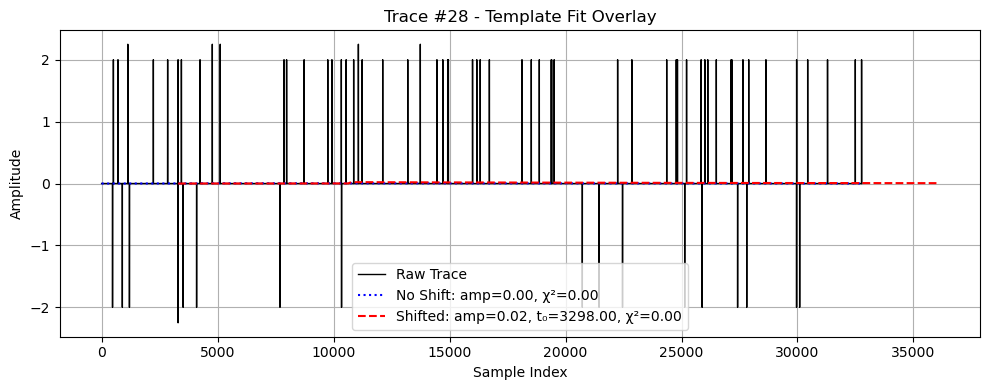

Fitting and plotting:  58%|█████▊    | 29/50 [00:15<00:10,  1.95it/s]

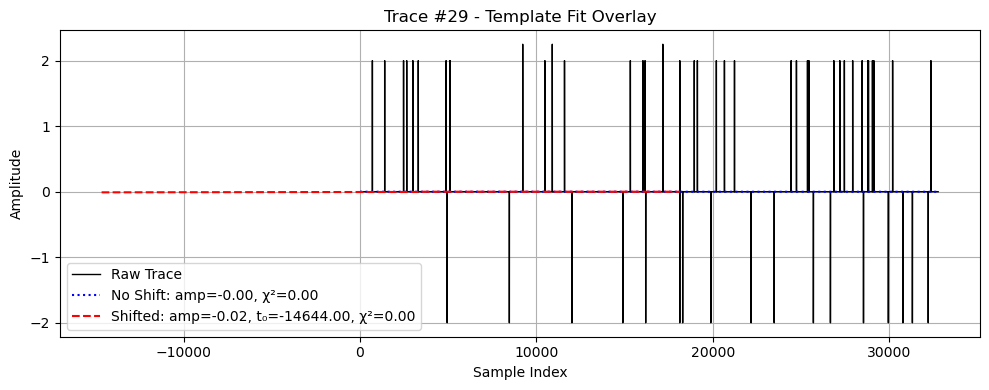

Fitting and plotting:  60%|██████    | 30/50 [00:15<00:09,  2.18it/s]

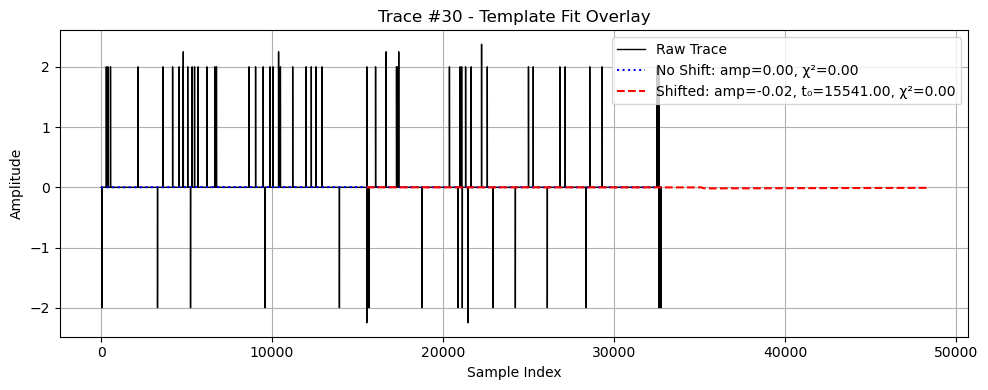

Fitting and plotting:  62%|██████▏   | 31/50 [00:16<00:08,  2.11it/s]

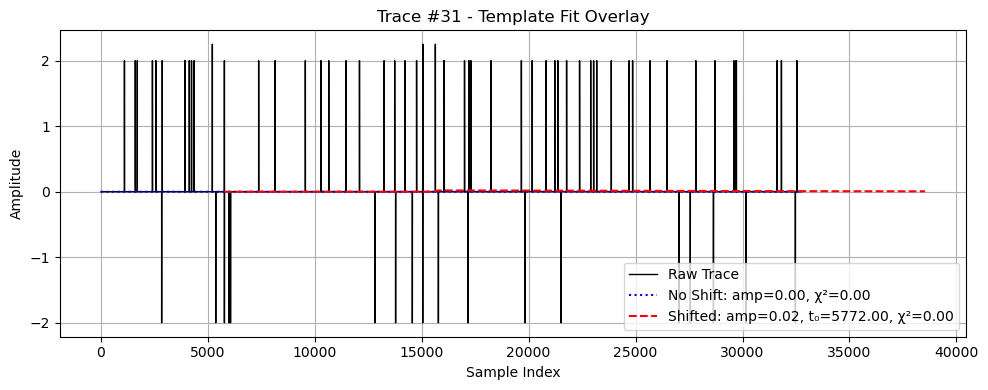

Fitting and plotting:  64%|██████▍   | 32/50 [00:16<00:08,  2.05it/s]

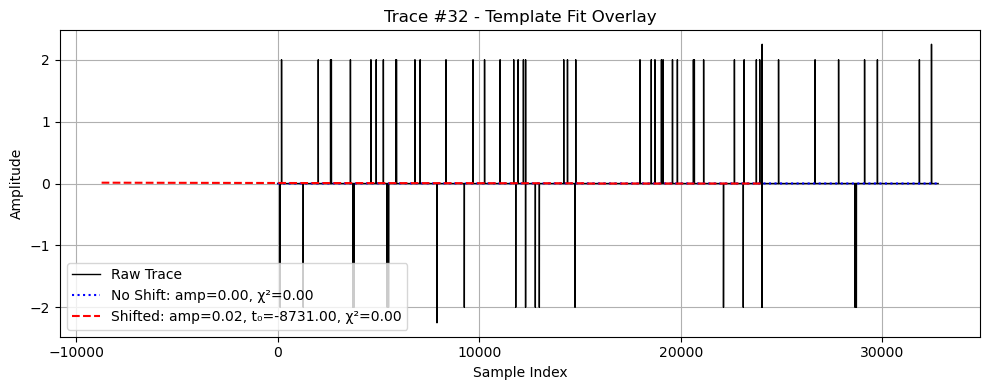

Fitting and plotting:  66%|██████▌   | 33/50 [00:17<00:08,  2.04it/s]

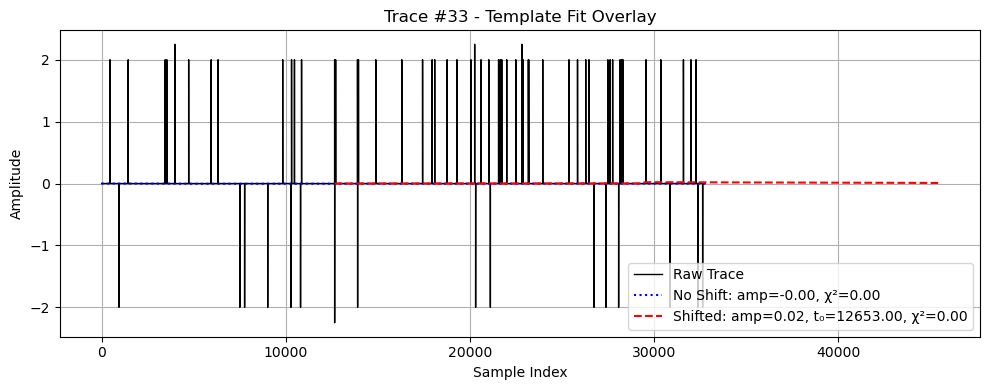

Fitting and plotting:  68%|██████▊   | 34/50 [00:17<00:07,  2.04it/s]

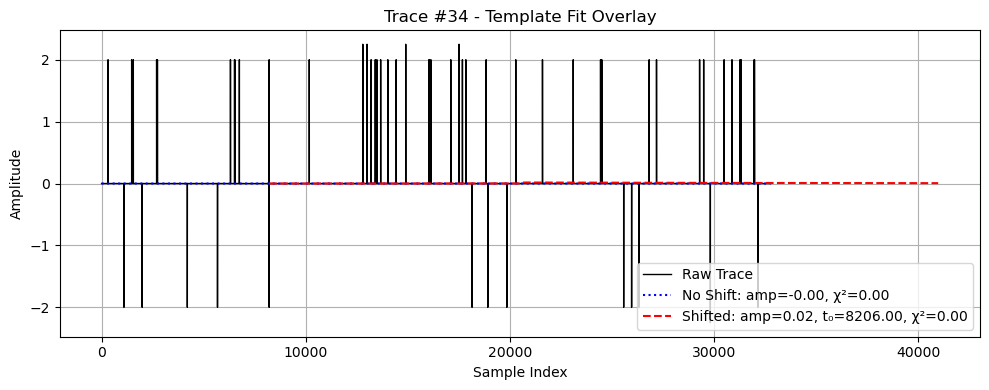

Fitting and plotting:  70%|███████   | 35/50 [00:18<00:07,  2.02it/s]

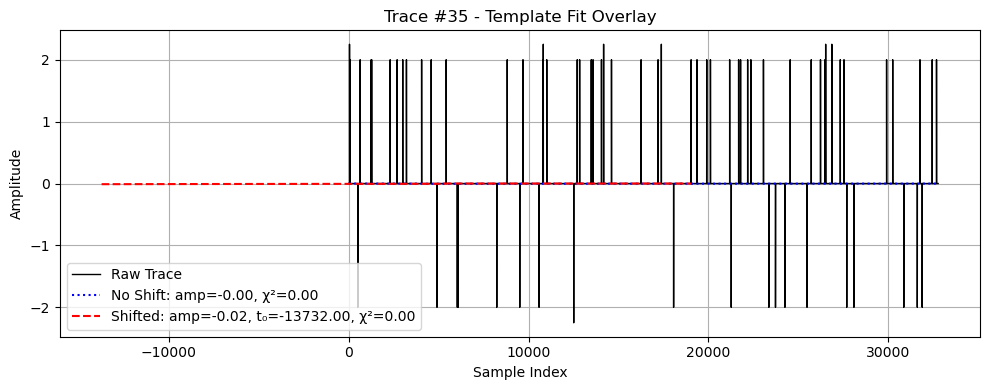

Fitting and plotting:  72%|███████▏  | 36/50 [00:18<00:06,  2.03it/s]

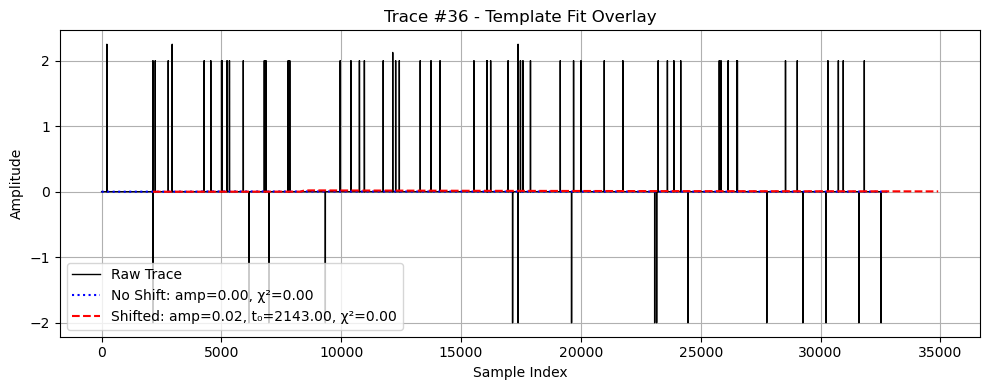

Fitting and plotting:  74%|███████▍  | 37/50 [00:19<00:06,  2.01it/s]

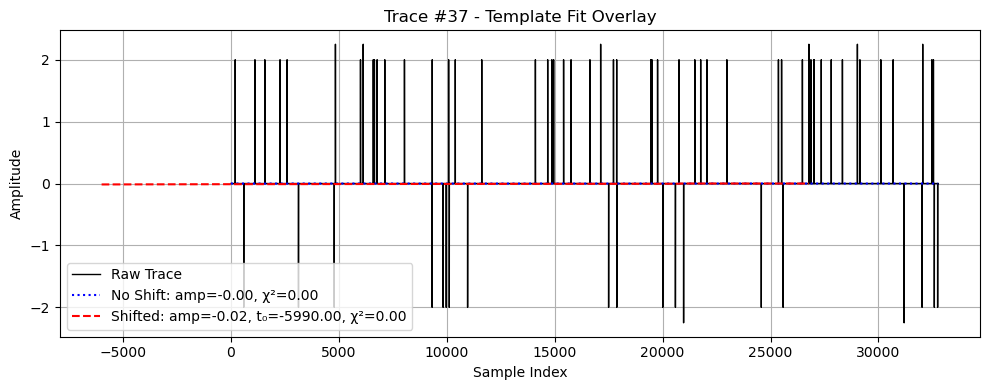

Fitting and plotting:  76%|███████▌  | 38/50 [00:19<00:06,  2.00it/s]

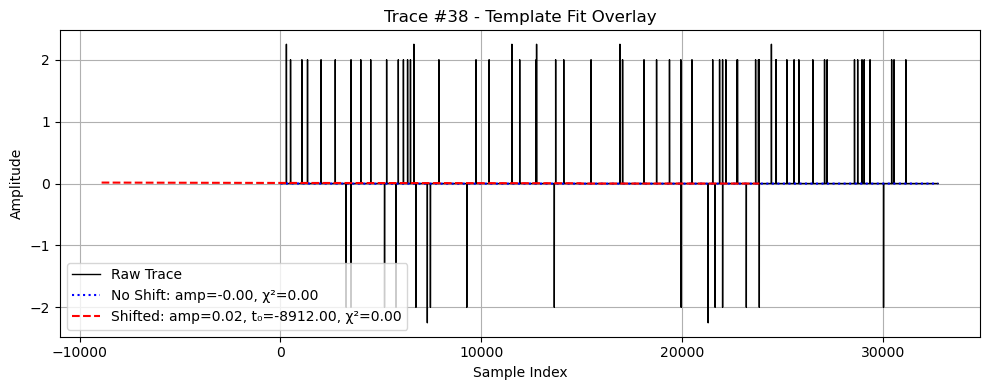

Fitting and plotting:  78%|███████▊  | 39/50 [00:20<00:05,  2.01it/s]

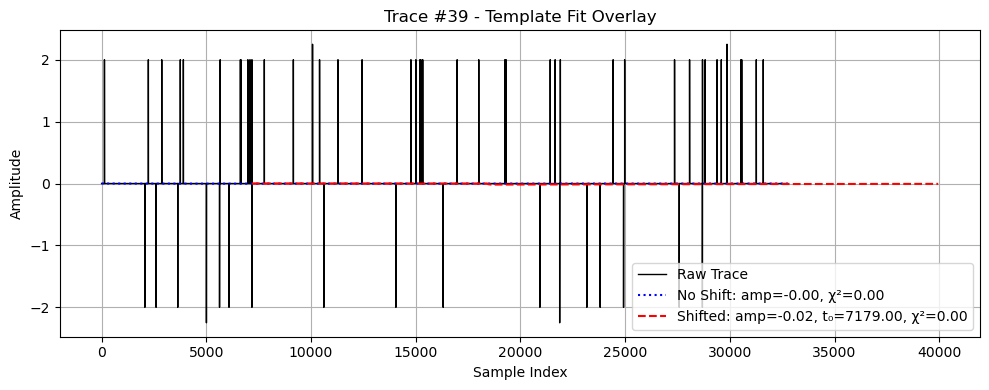

Fitting and plotting:  80%|████████  | 40/50 [00:20<00:04,  2.00it/s]

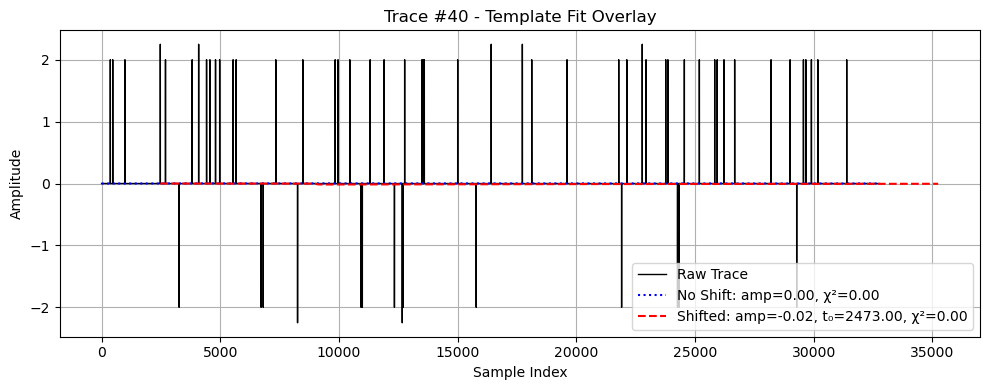

Fitting and plotting:  82%|████████▏ | 41/50 [00:21<00:04,  1.99it/s]

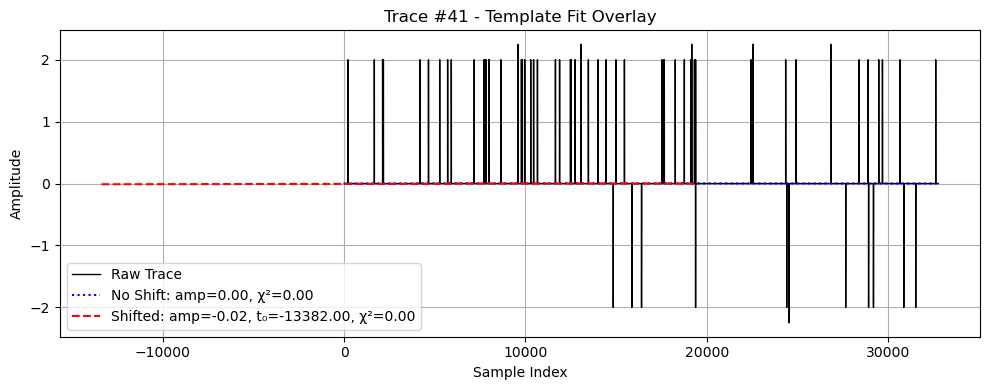

Fitting and plotting:  84%|████████▍ | 42/50 [00:21<00:03,  2.27it/s]

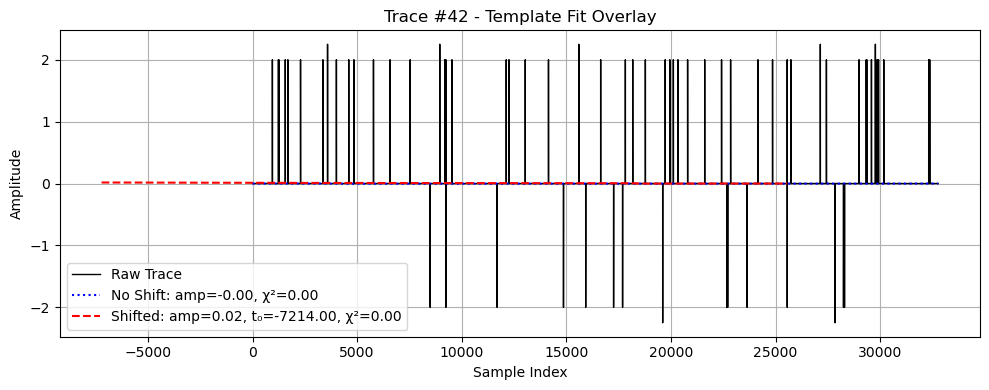

Fitting and plotting:  86%|████████▌ | 43/50 [00:21<00:03,  2.25it/s]

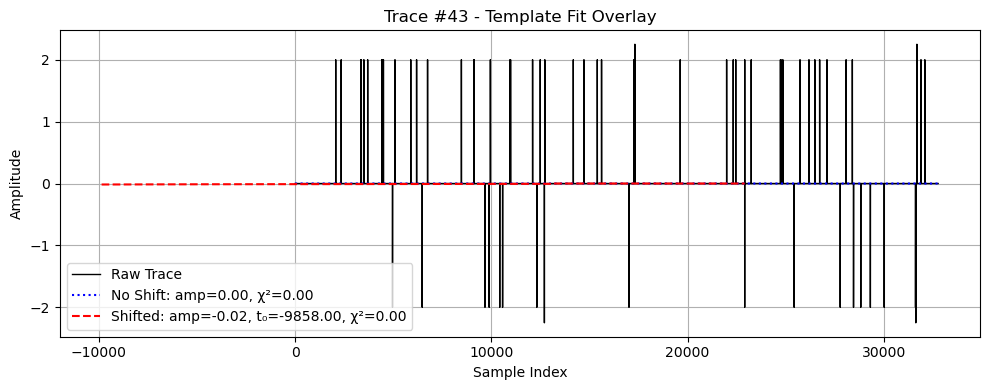

Fitting and plotting:  88%|████████▊ | 44/50 [00:22<00:02,  2.19it/s]

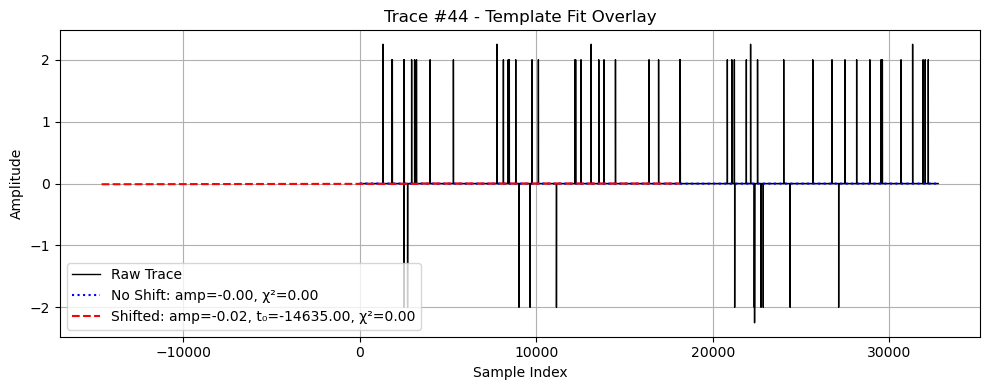

Fitting and plotting:  90%|█████████ | 45/50 [00:22<00:02,  2.15it/s]

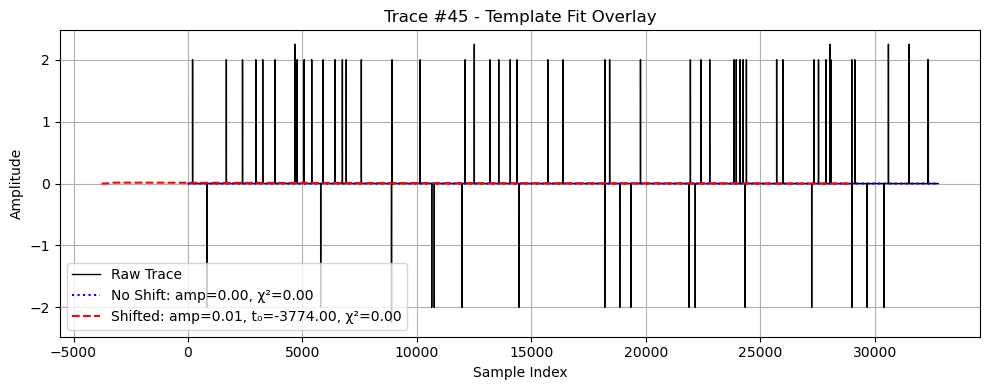

Fitting and plotting:  92%|█████████▏| 46/50 [00:23<00:01,  2.09it/s]

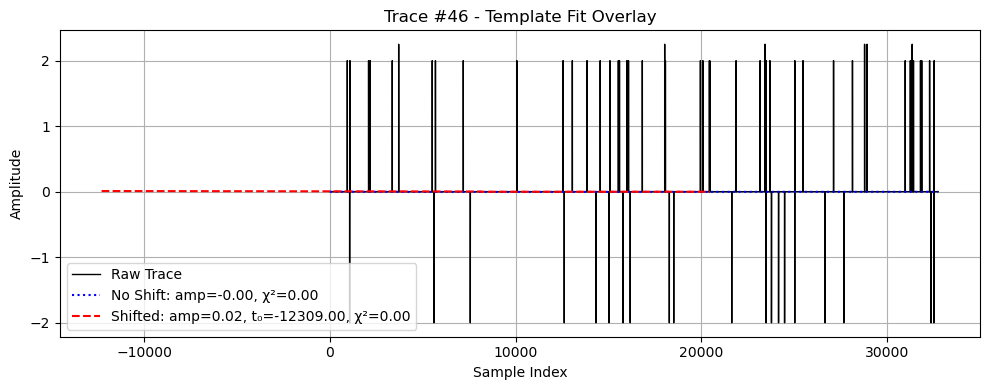

Fitting and plotting:  94%|█████████▍| 47/50 [00:23<00:01,  2.03it/s]

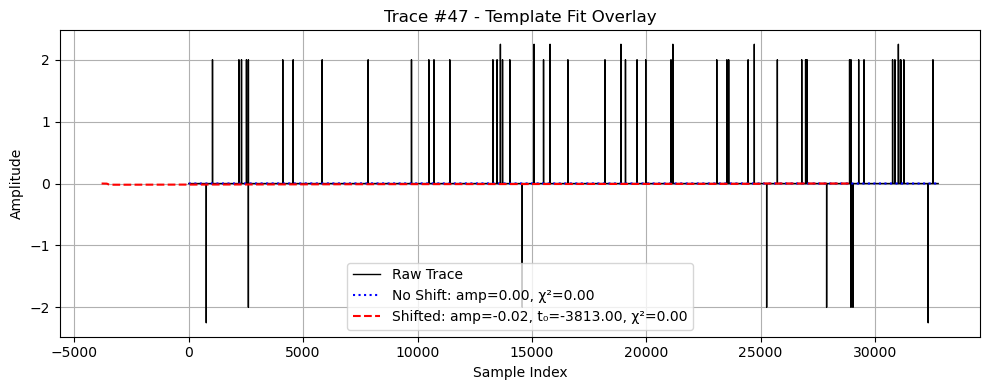

Fitting and plotting:  96%|█████████▌| 48/50 [00:24<00:00,  2.00it/s]

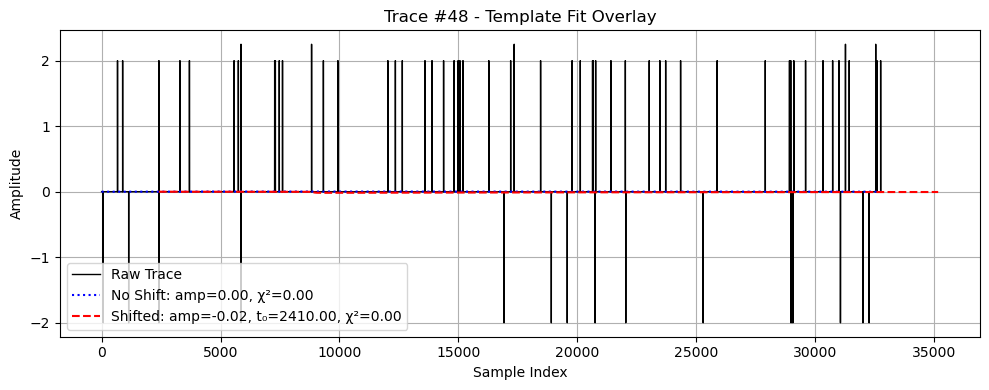

Fitting and plotting:  98%|█████████▊| 49/50 [00:24<00:00,  2.01it/s]

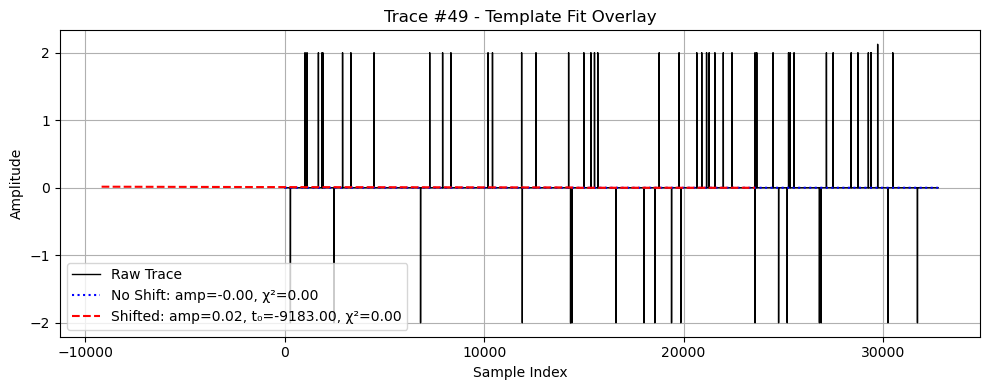

Fitting and plotting: 100%|██████████| 50/50 [00:25<00:00,  1.97it/s]


In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from tqdm import tqdm

# Load traces from .npz file
data = np.load("low_amplitude_traces.npz")
filtered_traces = data["traces"]  # adjust key if needed

# Load your template
template = np.load("../templates/template_K_alpha_no_baseline.npy")

# Fit and plot first N traces
n_traces = 50
x_template = np.arange(len(template))

for i in tqdm(range(n_traces), desc="Fitting and plotting"):
    trace = filtered_traces[i]

    # Fit without shift
    amp1, chi2_1 = trigger.fit(trace)

    # Fit with shift
    amp2, chi2_2, t0_2 = trigger.fit_with_shift(trace)

    # Interpolate and shift template by t0_2, and rescale by amp2
    interp_func = interp1d(x_template, template, kind='linear', fill_value=0, bounds_error=False)
    shifted_template = interp_func(x_template - t0_2) * amp2
    shifted_x = x_template + t0_2  # shift x-axis accordingly

    # Plot
    plt.figure(figsize=(10, 4))
    plt.plot(trace, label="Raw Trace", color="black", linewidth=1)
    
    # Annotate both fits with amp and chi2
    plt.plot(
        x_template,
        template * amp1,
        label=f"No Shift: amp={amp1:.2f}, χ²={chi2_1:.2f}",
        color="blue",
        linestyle=":"
    )
    plt.plot(
        shifted_x,
        shifted_template,
        label=f"Shifted: amp={amp2:.2f}, t₀={t0_2:.2f}, χ²={chi2_2:.2f}",
        color="red",
        linestyle="--"
    )

    plt.title(f"Trace #{i} - Template Fit Overlay")
    plt.xlabel("Sample Index")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
